In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,ReLU,UpSampling2D,MaxPool2D,Dropout,BatchNormalization,Layer,Activation
from tensorflow.keras import Model,mixed_precision
from tensorflow.keras.activations import sigmoid,tanh,leaky_relu
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU,CategoricalCrossentropy
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt

# os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["MLIR_CRASH_REPRODUCER_DIRECTORY"]="./crash"

import tensorflow as tf
print(tf.config.list_physical_devices())
tf.test.is_built_with_cuda()

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

2024-05-28 17:19:18.842600: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 17:19:18.871814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-28 17:19:20.441908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 17:19:20.465790: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 17:19:20.465938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

['000000', '000001', '000002', '000003', '000004']
['dataset/images/im_000000.png', 'dataset/images/im_000001.png', 'dataset/images/im_000002.png']
['dataset/images/im_043165.png', 'dataset/images/im_007547.png', 'dataset/images/im_008390.png']


2024-05-28 17:19:20.929838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 17:19:20.930039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 17:19:20.930168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

(128, 128, 6)
(128, 128)


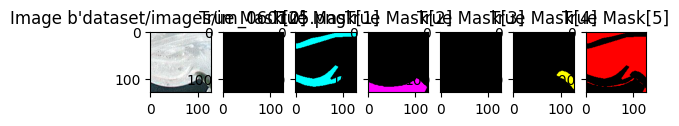

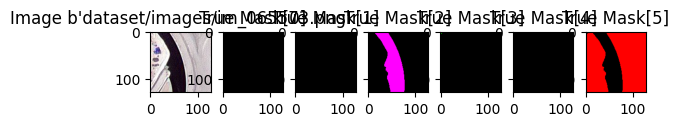

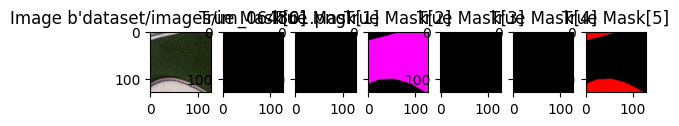

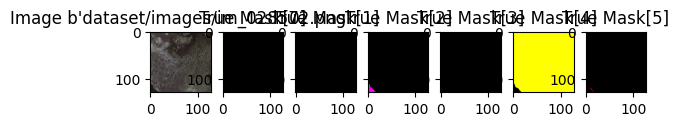

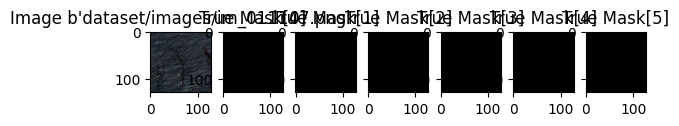

2024-05-28 17:19:23.421231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(128, 128, 6)
(128, 128)


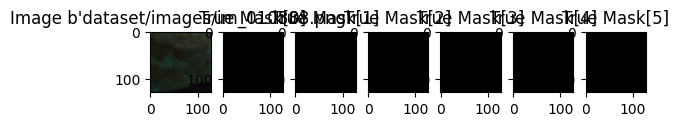

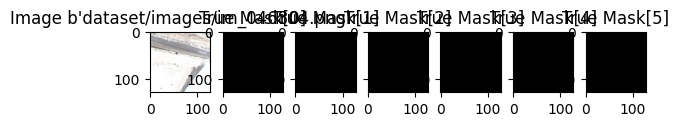

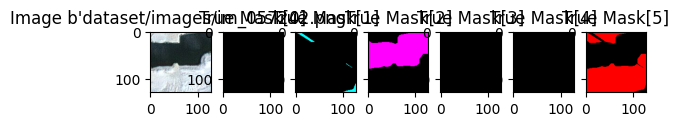

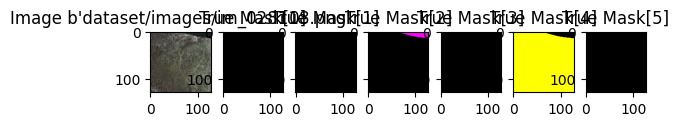

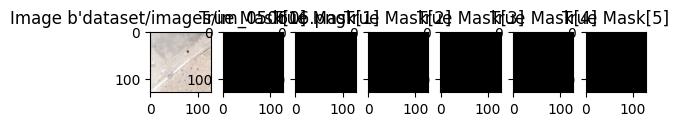

2024-05-28 17:19:24.841182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
from matplotlib import colors
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Directory where your images and masks are stored
images_dir = "dataset/images"
mask_directories = ["BUILDING", "ROAD", "WATER", "NONE", "FOREST", "LAND"]
modelname="unet-128-6ch-L-512-ACT-tanh-LOSS-dice+rms-MET-acc+iou"



# List all image filenames
image_filenames = os.listdir(images_dir)
image_filenames = [i for i in image_filenames if i.endswith(('.png'))]
image_filenames.sort()
mask_filenames=[i.split("_")[1].split(".")[0] for i in image_filenames]
print(mask_filenames[:5])
image_filenames = [i for i in image_filenames if i.endswith(('.png'))]
tar_img=[
    '043165',
    '007547',
    '008390',
    '005571',
    '060565',
    '022764',
    '023448',
    '001343',
    '005403',
    ]
# tar_mask=[
#     '043165',
#     '007547',
#     '008390',
#     '005571',
#     '060565',
#     '022764',
#     '023448',
#     '001343',
#     '005403',
#     ]


# Create file paths for images
image_paths = [os.path.join(images_dir, filename) for filename in image_filenames]
print(image_paths[:3])
tar_im_paths = [os.path.join(images_dir, "im_"+filename+".png") for filename in tar_img]
print(tar_im_paths[:3])
# Split data into train and test set
image_train_dataset, image_test_dataset, mask_train, mask_test= train_test_split(image_paths,mask_filenames, train_size=0.9, test_size=0.1, shuffle=True)

# Create TensorFlow dataset for images
train_dataset = tf.data.Dataset.from_tensor_slices((image_train_dataset,mask_train))
test_dataset = tf.data.Dataset.from_tensor_slices((image_test_dataset,mask_test))
tar_dataset = tf.data.Dataset.from_tensor_slices((tar_im_paths,tar_img))


# Function to load image and corresponding masks
def load_image_and_masks(image_filename,mask_filename):
    # image_path = tf.io.matching_files( image_filename)
    # print(image_path)
    image = tf.io.read_file(image_filename)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    # print("Image",type(image))
    
    
    # mask_filenames = find_mask_filenames(image_filename)
    # masks = []
    masks=[]
    for mask_dir in mask_directories:
        r=f"./dataset/masks/{mask_dir}_BW/msk_"+mask_filename+".png"
        mask = tf.io.read_file(r)
        mask = tf.image.decode_image(mask, channels=1)  # Read mask as 1 channel
        mask = tf.cast(mask, tf.float32) / 255.0
        masks.append(mask)
    # masks.append(mask)
    masks=tf.concat(masks,axis=2)
    # Combine masks into a single multi-channel mask
    # combined_mask = tf.concat(masks, axis=-1)
    
    return image, masks, image_filename

# Map loading function to image dataset
train_dataset = train_dataset.map(load_image_and_masks)
test_dataset = test_dataset.map(load_image_and_masks)
tar_dataset=tar_dataset.map(load_image_and_masks)


# Set batch size
batch_size = 1000
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(64)
tar_dataset = tar_dataset.batch(1)

# Prefetch dataset for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


cmaps=[
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (0., 0., 1., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (0.,1, 1., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1, 0., 1., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (0., 1., 0., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1., 1., 0., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1., 0., 0., 1.)]),
]

for images,masks, name in train_dataset.take(1):
    # Your training code here
    # for n-th whole masks
    print(masks[0].shape)
    # for n-th 1 layer mask
    print(masks[0][:,:,0].shape)
    for i in range(5):
        fig, (ax1,*am) = plt.subplots(1,7)
        ax1.imshow(images[i])
        ax1.set_title(f"Image {name[i]}")
        for k in range(0,6):
            am[k].imshow(masks[i,:,:,k],cmap=cmaps[k])
            am[k].set_title(f"True Mask[{k}]")

        plt.show()
for images,masks,name in test_dataset.take(1):
    # Your training code here
    # for n-th whole masks
    print(masks[0].shape)
    # for n-th 1 layer mask
    print(masks[0][:,:,0].shape)
    
    for i in range(5):
        fig, (ax1,*am) = plt.subplots(1,7)
        ax1.imshow(images[i])
        ax1.set_title(f"Image {name[i]}")
        for k in range(0,6):
            am[k].imshow(masks[i,:,:,k],cmap=cmaps[k])
            am[k].set_title(f"True Mask[{k}]")

        plt.show()

In [3]:
def create_upsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that upsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by an upsampling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        
        # x = ReLU()(x)
        # somehow we try tanh
        x = Activation(tanh)(x)
        # x = Activation(leaky_relu)(x)
        x = UpSampling2D(size=(2, 2))(x)
        return x
    return layer

def create_downsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that downsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by a max pooling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        # x = ReLU()(x)
        # somehow we try tanh
        x = Activation(tanh)(x)
        # x = Activation(leaky_relu)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        return x
    return layer



dropout_rate = 0.15

inputs = Input(shape=(128, 128, 3))

# # Encoder part of the DeepUNet
x = create_downsample_layer(64, 6, padding='same', kernel_initializer='he_normal')(inputs)
x = create_downsample_layer(128, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(256, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(512, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
# x = create_downsample_layer(1024, 6, padding='same', kernel_initializer='he_normal')(x)
# x = Dropout(dropout_rate)(x)
# x = create_downsample_layer(2048, 3, padding='same', kernel_initializer='he_normal')(x)
# x = Dropout(dropout_rate)(x)

# # Decoder part of the DeepUNet
# x = create_upsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
# x = Dropout(dropout_rate)(x)
# x = create_upsample_layer(512, 6, padding='same', kernel_initializer='he_normal')(x)
# x = Dropout(dropout_rate)(x)
x = create_upsample_layer(256, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(128, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(64, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(32, 6, padding='same', kernel_initializer='he_normal')(x)
outputs = Conv2D(6, 1, padding = 'same', activation='sigmoid')(x)


model = Model(inputs=inputs, outputs=outputs)
try:
    model.load_weights(f"models/{modelname}.keras")
except:
    pass
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 12,474,342 (47.59 MB)

 Trainable params: 12,471,462 (47.57 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [4]:
early_stop = EarlyStopping(monitor='val_mean_io_u', patience=90, verbose=1,
                           mode='max', restore_best_weights=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50,min_lr=1e-6,
#                               verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=90,min_lr=1e-6,
                              verbose=1, mode='min')

adam=Adam()

# filepath = "checkpoints/unet-128-6ch-{epoch:03d}-{loss:.4f}.keras"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

checkpoint = tf.train.Checkpoint(optimizer=adam, model=model)
manager = tf.train.CheckpointManager(
    checkpoint, directory=f"checkpoints/{modelname}/", max_to_keep=10)
status = checkpoint.restore(manager.latest_checkpoint)


training_cnt=0

In [5]:
import pandas as pd

# Sample DataFrame
metrics_file_name=f'metrics/{modelname}.csv'


try:
    metrics_df = pd.read_csv(metrics_file_name)
    print(metrics_df)
    training_cnt=metrics_df['epoch'].max() if not np.isnan(metrics_df['epoch'].max()) else 0
    max_iou=metrics_df['val_iou'].max() if not np.isnan(metrics_df['val_iou'].max()) else 0.0
    max_acc=metrics_df['val_acc'].max() if not np.isnan(metrics_df['val_acc'].max()) else 0.0
    min_loss=metrics_df['val_loss'].min() if not np.isnan(metrics_df['val_loss'].max()) else float('inf')
except:
    data = {'epoch': [],
    'val_acc': [],
    'val_loss': [],
    'val_iou': []}
    metrics_df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    metrics_df.to_csv(metrics_file_name, index=False)
    training_cnt=0
    max_iou=0.0
    max_acc=0.0
    min_loss=float('inf')
metrics_df = metrics_df.astype({"epoch": int})
data_template={'epoch': 0,
    'val_acc': 0.0,
    'val_loss': 0.0,
    'val_iou': 0.0}





      epoch   val_acc    val_loss   val_iou
0         1  0.535446  503.585663  0.417038
1         2  0.466277  534.512207  0.417038
2         3  0.496355  544.560852  0.417038
3         4  0.560721  493.469452  0.417038
4         5  0.664207  463.660461  0.417038
...     ...       ...         ...       ...
4535   4536  0.847274  216.404068  0.605434
4536   4537  0.848950  221.324020  0.561558
4537   4538  0.857016  219.021286  0.633968
4538   4539  0.845150  223.143280  0.592673
4539   4540  0.853428  225.457092  0.613261

[4540 rows x 4 columns]


In [6]:
print(status,manager)

<tensorflow.python.checkpoint.checkpoint.CheckpointLoadStatus object at 0x7aaf51a753f0> <tensorflow.python.checkpoint.checkpoint_management.CheckpointManager object at 0x7ab018d6bca0>


In [7]:
def dice_loss(y_true, y_pred):
    # Flatten the predictions and ground truth

    y_true_flat = tf.reshape(y_true,  [-1, tf.reduce_prod(tf.shape(y_true)[2:])])

    # y_true_flat = tf.reshape(y_true,  [-1])
    y_pred_flat = tf.reshape(y_pred,  [-1, tf.reduce_prod(tf.shape(y_pred)[2:])])
    # y_pred_flat = tf.reshape(y_pred,  [-1])
    # print(y_true.shape)
    # print(y_true_flat.shape)

    # Compute the intersection and union
    
    # intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat,axis=[0])+1e-6
    # union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    union = tf.reduce_sum(y_true_flat,axis=[0]) + tf.reduce_sum(y_pred_flat,axis=[0])+1e-6
    

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union
    dice_loss=tf.reduce_sum(tf.math.abs(dice_loss))
    print(intersection,dice_loss)

    return dice_loss

def dice_loss_w_rms(y_true, y_pred):
    # Flatten the predictions and ground truth

    y_true_flat = tf.reshape(y_true,  [-1, tf.reduce_prod(tf.shape(y_true)[2:])])
    # y_true_flat = tf.reshape(y_true,  [-1])
    y_pred_flat = tf.reshape(y_pred,  [-1, tf.reduce_prod(tf.shape(y_pred)[2:])])
    # y_pred_flat = tf.reshape(y_pred,  [-1])
    # print(y_true.shape)
    # print(y_true_flat.shape)
    sq_dif=tf.square(y_true_flat-y_pred_flat)
    reduce_sq_dif=tf.reduce_mean(sq_dif)
    sqrt=tf.sqrt(reduce_sq_dif)

    # Compute the intersection and union
    
    # intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat,axis=[0])+1e-6
    # union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    union = tf.reduce_sum(y_true_flat,axis=[0]) + tf.reduce_sum(y_pred_flat,axis=[0])+1e-6
    

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union
    dice_loss=tf.reduce_sum(tf.math.abs(dice_loss))
    print(intersection,dice_loss)

    return dice_loss+sqrt
    # return sqrt


iou = MeanIoU(num_classes=6)  # One for all classes
# categorical_accuracy = CategoricalCrossentropy(from_logits=True)
# alpha = 0.7  # Weight for cross-entropy loss
# beta = 1 - alpha  # Weight for Dice loss
# dice_loss = losses.BinaryCrossentropy(from_logits=True)
# total_loss = alpha * losses.categorical_crossentropy(from_logits=True) + beta * dice_loss


# Compile the model with the Dice loss
# model.compile(loss=[dice_loss,dice_loss,dice_loss,dice_loss,dice_loss,dice_loss], optimizer='adam', metrics=['accuracy','accuracy','accuracy','accuracy','accuracy','accuracy'])
model.compile(loss=[dice_loss_w_rms], optimizer=adam, metrics=["accuracy",iou])

for a, b, name in test_dataset.take(1):
# test,t=test_dataset.take(1)
    print(type(a),len(b))
    im_test=a
    msk_test=b
    im_name=name
    print(msk_test[0].shape)
print(dice_loss(msk_test[2],msk_test[1]))
print(dice_loss_w_rms(msk_test[1],msk_test[2]))
# dice_loss(msk_test[0,:,:,0],msk_test[0,:,:,1])


<class 'tensorflow.python.framework.ops.EagerTensor'> 64
(128, 128, 6)
tf.Tensor([1.000e-06 1.000e-06 1.000e-06 1.000e-06 1.000e-06 8.698e+03], shape=(6,), dtype=float32) tf.Tensor(5.3064346, shape=(), dtype=float32)
tf.Tensor(5.3064346, shape=(), dtype=float32)
tf.Tensor([1.000e-06 1.000e-06 1.000e-06 1.000e-06 1.000e-06 8.698e+03], shape=(6,), dtype=float32) tf.Tensor(5.3064346, shape=(), dtype=float32)
tf.Tensor(5.701874, shape=(), dtype=float32)


2024-05-28 17:19:26.341137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:

for a, b, name in test_dataset.take(1):
# test,t=test_dataset.take(1)
    print(type(a),len(b))
    im_test=a
    msk_test=b
    im_name=name

    

<class 'tensorflow.python.framework.ops.EagerTensor'> 64


2024-05-28 17:19:26.535299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
from random import randint,sample
import threading
from queue import Queue


num_epochs = 100
batch_size = 8
# Set seed
# tf.random.set_seed(42)
# tf.random.set_seed(1)



def process_history(history):
    global training_cnt
    global metrics_df
    for i in history.epoch:
        training_cnt+=1
        data_template['epoch']=training_cnt
        data_template['val_acc']=history.history['val_accuracy'][i]
        data_template['val_loss']=history.history['val_loss'][i]
        data_template['val_iou']=history.history['val_mean_io_u'][i]
        

        metrics_df=pd.concat([metrics_df, pd.DataFrame([data_template])], ignore_index=True)
    metrics_df.to_csv(metrics_file_name, index=False)

class LogWriter:
    def __init__(self):
        # self.log_file = log_file
        self.log_queue = Queue()
        self.thread = threading.Thread(target=self._write_logs)
        self.thread.daemon = True
        self.thread.start()

    def _write_logs(self):
        global metrics_df
        while True:
            hist = self.log_queue.get()
            if hist is None:  # Sentinel to stop the thread
                break
            # with open(self.log_file, 'a') as f:
            #     f.write(message + "\n")
            metrics_df=pd.concat([metrics_df, pd.DataFrame([hist])], ignore_index=True)
            metrics_df.to_csv(metrics_file_name, index=False)
            self.log_queue.task_done()

    def write_log(self, message):
        self.log_queue.put(message)

    def stop(self):
        self.log_queue.put(None)
        self.thread.join()

log_writer=LogWriter()


class save_if_better_cb(Callback):
    def on_epoch_end(self, epoch, logs=None):
        global max_iou,min_loss
        global training_cnt
        global metrics_df
        global manager
        global data_template
        global log_writer
        training_cnt+=1
        data_template['epoch']=training_cnt
        data_template['val_acc']=logs.get("val_accuracy")
        data_template['val_loss']=logs.get('val_loss')
        data_template['val_iou']=logs.get('val_mean_io_u')
        log_writer.write_log(data_template)
        # if logs.get('val_mean_io_u') > max_iou or logs.get('val_loss') < min_loss:
        #     max_iou=logs.get('val_mean_io_u')
        #     manager.save()
        #     print(f"\n\nEpoch {training_cnt} is better by {max_iou}, Saving the model...\n\n")
        #     model_path=f"models/{modelname}.keras"
        #     model.save(model_path)
            

        # metrics_df=pd.concat([metrics_df, pd.DataFrame([data_template])], ignore_index=True)
        # metrics_df.to_csv(metrics_file_name, index=False)

        # print("End epoch {} of training; got log keys: {}".format(epoch, keys))



def show_picture_compare(original, res, msk, name):
    global training_cnt
    main="""
        ........
        XXABCDEF
        XXGHIJKL
        ........
        """
    fig, am = plt.subplot_mosaic(main)
    fig.set_size_inches(16,8)
    plt.subplots_adjust(hspace=0.25)
    am["X"].set_title(f"Image {name.split('/')[-1]}")

    am["X"].imshow(original)    

    for k in range(0,6):
        am[chr(ord("A")+k)].imshow(msk[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        am[chr(ord("A")+k)].set_title(f"[{mask_directories[k]}]")
        am[chr(ord("G")+k)].imshow(res[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        # am[chr(ord("G")+k)].set_title(f"[Pred]")
        # plt.tight_layout()
    
    cmp_path=f'compare_img/{modelname}/{name.split("/")[-1].split(".")[0]}/'
    if not os.path.exists(cmp_path):
        os.makedirs(cmp_path)
    plt.savefig(f'{cmp_path}{training_cnt}.png',bbox_inches='tight')
    plt.close()
    # plt.show()

class write_im_perf(Callback):
    def on_epoch_end(self, epoch, logs=None):
        global max_iou,min_loss
        global training_cnt
        global metrics_df
        global manager
        global model
        global tar_dataset
        if training_cnt%5==0:
            for im,msk,im_name in tar_dataset.take(len(tar_img)):
                # print(im_test[idx].shape)
                
                ori=im[0]
                res=model.predict(ori[None,...])[0]
                msk=msk[0]
                name=im_name[0]
                name=str(name.numpy()).replace("'","")
                show_picture_compare(ori, res, msk, name)

        # print("End epoch {} of training; got log keys: {}".format(epoch, keys))

for images, masks, _ in train_dataset.take(70):

    # x,y=preprocess_images_and_masks(dataset_path,i*1000,1000)
    # train_images,train_masks,val_images,val_masks,test_images,test_masks=split(x,y)
    print(f"Take {training_cnt}")
    # training_cnt+=1
    # print(masks[0].shape)


    # Train the UNet model on the training data
    history = model.fit(#dataset,
                        images,
                        masks,
                        batch_size=batch_size, epochs=num_epochs,
                        # callbacks=[early_stop, reduce_lr],
                        callbacks=[early_stop,save_if_better_cb(),write_im_perf()],
                        validation_split=0.2,
                        verbose=1)
    manager.save()
    model_path=f"models/{modelname}.keras"
    model.save(model_path)
    epochs_list = list(range(1, len(history.history['val_loss']) + 1))
    val_loss = history.history['val_loss']
    val_accuracy_k = history.history.keys()
    if training_cnt>5000:
        break

    # process_history(history)

    # Plot the epoch vs val_loss

    # Create a second y-axis for the val_accuracy
    # ax2 = ax1.twinx()
    # ax2.plot(epochs_list, val_loss, 'k-')
    # ax2.set_ylabel('Validation Loss', color='b')

    # Set the same scaling on the y-axes
    # ax1.set_ylim([0.0, 1])
    # ax2.set_ylim([0.0, 1])
    # idx_list=[randint(0,63) for _ in range(5)]
    
    # show im

    # idx_list=sample(range(0,63),5)
    # for idx in idx_list:
    #     # print(im_test[idx].shape)
        
    #     ori=im_test[idx]
    #     res=model.predict(ori[None,...])[0]
    #     msk=msk_test[idx]
    #     name=im_name[idx]
    #     name=str(name.numpy()).replace("'","")
    #     show_picture_compare(ori, res, msk, name)

Take 4540
Epoch 1/100
Tensor("compile_loss/dice_loss_w_rms/add:0", shape=(768,), dtype=float32) Tensor("compile_loss/dice_loss_w_rms/Sum_3:0", shape=(), dtype=float32)
Tensor("compile_loss/dice_loss_w_rms/add:0", shape=(768,), dtype=float32) Tensor("compile_loss/dice_loss_w_rms/Sum_3:0", shape=(), dtype=float32)


I0000 00:00:1716887970.474421 1301951 service.cc:145] XLA service 0x7aae0c020680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716887970.474442 1301951 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-28 17:19:30.894313: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  3/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8876 - loss: 197.1406 - mean_io_u: 0.6509  

I0000 00:00:1716887980.597044 1301951 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8447 - loss: 267.1823 - mean_io_u: 0.5922Tensor("compile_loss/dice_loss_w_rms/add:0", shape=(768,), dtype=float32) Tensor("compile_loss/dice_loss_w_rms/Sum_3:0", shape=(), dtype=float32)
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8446 - loss: 267.3766 - mean_io_u: 0.5907 - val_accuracy: 0.8329 - val_loss: 326.5755 - val_mean_io_u: 0.6826
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8468 - loss: 272.4942 - mean_io_u: 0.5899 - val_accuracy: 0.8603 - val_loss: 306.8972 - val_mean_io_u: 0.7296
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8415 - loss: 287.9158 - mean_io_u: 0.5989 - val_accuracy: 0.8542 - val_loss: 313.8445 - val_mean_io_u: 0.7182
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8558 - loss: 264.6092 - mean_io_u: 0.5928 - val_accuracy: 0.8434 - val_loss: 310.5699 - val_mean_io_u: 0.6370
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/steptep - 

2024-05-28 17:20:08.984277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8695 - loss: 255.3860 - mean_io_u: 0.5884 - val_accuracy: 0.8591 - val_loss: 300.8650 - val_mean_io_u: 0.6114
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8826 - loss: 243.8472 - mean_io_u: 0.6140 - val_accuracy: 0.8638 - val_loss: 308.1582 - val_mean_io_u: 0.6559
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8896 - loss: 233.3350 - mean_io_u: 0.6060 - val_accuracy: 0.8615 - val_loss: 303.5489 - val_mean_io_u: 0.6127
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8922 - loss: 226.0713 - mean_io_u: 0.5966 - val_accuracy: 0.8671 - val_loss: 301.3516 - val_mean_io_u: 0.6466
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8894 - loss: 250.4651 - mean_io_u: 0.595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-05-28 17:20:35.355232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8839 - loss: 228.8476 - mean_io_u: 0.5860 - val_accuracy: 0.8621 - val_loss: 312.2551 - val_mean_io_u: 0.6299
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8988 - loss: 238.7894 - mean_io_u: 0.5839 - val_accuracy: 0.8516 - val_loss: 312.4399 - val_mean_io_u: 0.6176
Epoch 13/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8979 - loss: 234.8622 - mean_io_u: 0.5696 - val_accuracy: 0.8623 - val_loss: 314.8345 - val_mean_io_u: 0.7054
Epoch 14/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8845 - loss: 245.6473 - mean_io_u: 0.5742 - val_accuracy: 0.8709 - val_loss: 299.4744 - val_mean_io_u: 0.6539
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9037 - loss: 225.8743 - mean_io_u: 0.604
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:21:02.134455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9040 - loss: 224.0994 - mean_io_u: 0.6023 - val_accuracy: 0.8690 - val_loss: 305.8256 - val_mean_io_u: 0.5739
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9048 - loss: 234.4155 - mean_io_u: 0.5830 - val_accuracy: 0.8487 - val_loss: 328.7871 - val_mean_io_u: 0.6961
Epoch 18/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9048 - loss: 233.3066 - mean_io_u: 0.6128 - val_accuracy: 0.8692 - val_loss: 302.0205 - val_mean_io_u: 0.6505
Epoch 19/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9072 - loss: 212.7722 - mean_io_u: 0.6192 - val_accuracy: 0.8581 - val_loss: 310.7357 - val_mean_io_u: 0.6758
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9075 - loss: 216.2705 - mean_io_u: 0.612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:21:28.772467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9029 - loss: 220.2409 - mean_io_u: 0.5989 - val_accuracy: 0.8684 - val_loss: 303.6629 - val_mean_io_u: 0.6873
Epoch 22/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9031 - loss: 221.6490 - mean_io_u: 0.5954 - val_accuracy: 0.8640 - val_loss: 306.2993 - val_mean_io_u: 0.6898
Epoch 23/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9159 - loss: 197.9459 - mean_io_u: 0.6140 - val_accuracy: 0.8643 - val_loss: 302.0986 - val_mean_io_u: 0.6445
Epoch 24/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9114 - loss: 220.8217 - mean_io_u: 0.5838 - val_accuracy: 0.8676 - val_loss: 297.5425 - val_mean_io_u: 0.6260
Epoch 25/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9157 - loss: 217.6953 - mean_io_u: 0.597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:21:55.248086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9141 - loss: 225.2883 - mean_io_u: 0.5886 - val_accuracy: 0.8725 - val_loss: 301.8947 - val_mean_io_u: 0.6270
Epoch 27/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9203 - loss: 212.4140 - mean_io_u: 0.6098 - val_accuracy: 0.8691 - val_loss: 305.4838 - val_mean_io_u: 0.6125
Epoch 28/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9152 - loss: 221.4707 - mean_io_u: 0.5900 - val_accuracy: 0.8713 - val_loss: 301.0088 - val_mean_io_u: 0.7087
Epoch 29/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9194 - loss: 215.2785 - mean_io_u: 0.5890 - val_accuracy: 0.8680 - val_loss: 307.6501 - val_mean_io_u: 0.7047
Epoch 30/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9235 - loss: 212.6097 - mean_io_u: 0.615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:22:21.592524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9254 - loss: 209.4562 - mean_io_u: 0.6031 - val_accuracy: 0.8704 - val_loss: 298.6495 - val_mean_io_u: 0.6335
Epoch 32/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9256 - loss: 205.8674 - mean_io_u: 0.5869 - val_accuracy: 0.8650 - val_loss: 301.1490 - val_mean_io_u: 0.5783
Epoch 33/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9231 - loss: 202.4529 - mean_io_u: 0.6038 - val_accuracy: 0.8655 - val_loss: 301.0449 - val_mean_io_u: 0.6244
Epoch 34/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9229 - loss: 208.2060 - mean_io_u: 0.5967 - val_accuracy: 0.8665 - val_loss: 303.7501 - val_mean_io_u: 0.6412
Epoch 35/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9177 - loss: 206.7286 - mean_io_u: 0.584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

2024-05-28 17:22:47.776941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9293 - loss: 204.5073 - mean_io_u: 0.5940 - val_accuracy: 0.8612 - val_loss: 311.2910 - val_mean_io_u: 0.5901
Epoch 37/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9249 - loss: 229.6023 - mean_io_u: 0.5808 - val_accuracy: 0.8634 - val_loss: 304.2012 - val_mean_io_u: 0.6558
Epoch 38/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9272 - loss: 209.9678 - mean_io_u: 0.5956 - val_accuracy: 0.8625 - val_loss: 304.7341 - val_mean_io_u: 0.6359
Epoch 39/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9258 - loss: 204.4790 - mean_io_u: 0.5938 - val_accuracy: 0.8729 - val_loss: 303.7117 - val_mean_io_u: 0.6389
Epoch 40/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9296 - loss: 204.9368 - mean_io_u: 0.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

2024-05-28 17:23:14.351990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9285 - loss: 208.6455 - mean_io_u: 0.6155 - val_accuracy: 0.8464 - val_loss: 315.2715 - val_mean_io_u: 0.5317
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9242 - loss: 205.9133 - mean_io_u: 0.5657 - val_accuracy: 0.8697 - val_loss: 304.6179 - val_mean_io_u: 0.6000
Epoch 43/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9303 - loss: 197.0016 - mean_io_u: 0.5753 - val_accuracy: 0.8334 - val_loss: 282.2796 - val_mean_io_u: 0.7249
Epoch 44/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9176 - loss: 158.2080 - mean_io_u: 0.5799 - val_accuracy: 0.8091 - val_loss: 262.9022 - val_mean_io_u: 0.6068
Epoch 45/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9198 - loss: 151.6424 - mean_io_u: 0.570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:23:40.551366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9188 - loss: 147.4012 - mean_io_u: 0.5680 - val_accuracy: 0.8699 - val_loss: 246.9964 - val_mean_io_u: 0.6536
Epoch 47/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9226 - loss: 147.0207 - mean_io_u: 0.5738 - val_accuracy: 0.8680 - val_loss: 238.2858 - val_mean_io_u: 0.6193
Epoch 48/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9278 - loss: 129.5644 - mean_io_u: 0.5913 - val_accuracy: 0.8617 - val_loss: 244.9942 - val_mean_io_u: 0.6576
Epoch 49/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9301 - loss: 120.9929 - mean_io_u: 0.5920 - val_accuracy: 0.8642 - val_loss: 247.6092 - val_mean_io_u: 0.5831
Epoch 50/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepstep - accuracy: 0.9246 - loss: 121.2719 - mean_io_u: 0.588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

2024-05-28 17:24:07.439928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9266 - loss: 117.9333 - mean_io_u: 0.5954 - val_accuracy: 0.8575 - val_loss: 239.1236 - val_mean_io_u: 0.5210
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9259 - loss: 128.6908 - mean_io_u: 0.5846 - val_accuracy: 0.8665 - val_loss: 240.9501 - val_mean_io_u: 0.6676
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9222 - loss: 125.8616 - mean_io_u: 0.5923 - val_accuracy: 0.8632 - val_loss: 240.6159 - val_mean_io_u: 0.5835
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9301 - loss: 133.6643 - mean_io_u: 0.5891 - val_accuracy: 0.8480 - val_loss: 238.5132 - val_mean_io_u: 0.5201
Epoch 55/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9328 - loss: 128.4956 - mean_io_u: 0.605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:24:32.962412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9277 - loss: 124.1350 - mean_io_u: 0.5957 - val_accuracy: 0.8704 - val_loss: 232.8401 - val_mean_io_u: 0.6163
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9325 - loss: 111.4412 - mean_io_u: 0.6182 - val_accuracy: 0.8686 - val_loss: 240.7788 - val_mean_io_u: 0.5642
Epoch 58/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9304 - loss: 105.8573 - mean_io_u: 0.6065 - val_accuracy: 0.8640 - val_loss: 235.5192 - val_mean_io_u: 0.6463
Epoch 59/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9291 - loss: 117.6299 - mean_io_u: 0.5984 - val_accuracy: 0.8557 - val_loss: 253.9110 - val_mean_io_u: 0.6396
Epoch 60/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9255 - loss: 128.2871 - mean_io_u: 0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:24:58.780105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9369 - loss: 116.6990 - mean_io_u: 0.5779 - val_accuracy: 0.8644 - val_loss: 240.1523 - val_mean_io_u: 0.6645
Epoch 62/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9356 - loss: 106.0518 - mean_io_u: 0.5941 - val_accuracy: 0.8705 - val_loss: 237.3088 - val_mean_io_u: 0.6914
Epoch 63/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9327 - loss: 109.2396 - mean_io_u: 0.5976 - val_accuracy: 0.8654 - val_loss: 232.3001 - val_mean_io_u: 0.5388
Epoch 64/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9384 - loss: 110.4283 - mean_io_u: 0.6006 - val_accuracy: 0.8621 - val_loss: 233.5086 - val_mean_io_u: 0.5564
Epoch 65/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9275 - loss: 122.2777 - mean_io_u: 0.603
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

2024-05-28 17:25:25.005469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9340 - loss: 121.4540 - mean_io_u: 0.5948 - val_accuracy: 0.8687 - val_loss: 231.1945 - val_mean_io_u: 0.6060
Epoch 67/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9366 - loss: 114.7283 - mean_io_u: 0.6009 - val_accuracy: 0.8640 - val_loss: 235.0014 - val_mean_io_u: 0.6168
Epoch 68/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9361 - loss: 111.0329 - mean_io_u: 0.6219 - val_accuracy: 0.8671 - val_loss: 234.4005 - val_mean_io_u: 0.6808
Epoch 69/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9383 - loss: 105.2689 - mean_io_u: 0.6295 - val_accuracy: 0.8619 - val_loss: 240.2632 - val_mean_io_u: 0.6483
Epoch 70/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9229 - loss: 109.5566 - mean_io_u: 0.610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:25:50.799104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9328 - loss: 112.5482 - mean_io_u: 0.6220 - val_accuracy: 0.8628 - val_loss: 230.1264 - val_mean_io_u: 0.6828
Epoch 72/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9410 - loss: 98.4026 - mean_io_u: 0.6424 - val_accuracy: 0.8692 - val_loss: 234.1897 - val_mean_io_u: 0.6818
Epoch 73/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9356 - loss: 104.9504 - mean_io_u: 0.6215 - val_accuracy: 0.8619 - val_loss: 231.5955 - val_mean_io_u: 0.6220
Epoch 74/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9395 - loss: 104.5199 - mean_io_u: 0.6205 - val_accuracy: 0.8662 - val_loss: 227.2943 - val_mean_io_u: 0.5804
Epoch 75/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9373 - loss: 98.6449 - mean_io_u: 0.619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2024-05-28 17:26:16.712034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9387 - loss: 110.5972 - mean_io_u: 0.6148 - val_accuracy: 0.8667 - val_loss: 237.3843 - val_mean_io_u: 0.6495
Epoch 77/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9353 - loss: 119.9808 - mean_io_u: 0.5947 - val_accuracy: 0.8648 - val_loss: 238.1581 - val_mean_io_u: 0.6179
Epoch 78/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9390 - loss: 102.1472 - mean_io_u: 0.6115 - val_accuracy: 0.8380 - val_loss: 261.5665 - val_mean_io_u: 0.5312
Epoch 79/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9394 - loss: 105.5328 - mean_io_u: 0.6071 - val_accuracy: 0.8678 - val_loss: 232.7603 - val_mean_io_u: 0.5921
Epoch 80/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9393 - loss: 109.1021 - mean_io_u: 0.606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:26:43.411690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9419 - loss: 101.0421 - mean_io_u: 0.6365 - val_accuracy: 0.8679 - val_loss: 236.7130 - val_mean_io_u: 0.6713
Epoch 82/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9350 - loss: 108.4513 - mean_io_u: 0.6114 - val_accuracy: 0.8674 - val_loss: 233.3367 - val_mean_io_u: 0.5812
Epoch 83/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9406 - loss: 100.7641 - mean_io_u: 0.6191 - val_accuracy: 0.8649 - val_loss: 231.9753 - val_mean_io_u: 0.5616
Epoch 84/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9449 - loss: 101.3410 - mean_io_u: 0.6223 - val_accuracy: 0.8700 - val_loss: 229.6031 - val_mean_io_u: 0.6132
Epoch 85/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9449 - loss: 104.2622 - mean_io_u: 0.613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:27:09.272376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9420 - loss: 107.9471 - mean_io_u: 0.6018 - val_accuracy: 0.8623 - val_loss: 241.5091 - val_mean_io_u: 0.6302
Epoch 87/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9431 - loss: 105.3419 - mean_io_u: 0.6079 - val_accuracy: 0.8681 - val_loss: 231.7240 - val_mean_io_u: 0.6254
Epoch 88/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9423 - loss: 97.4895 - mean_io_u: 0.6224 - val_accuracy: 0.8703 - val_loss: 227.4984 - val_mean_io_u: 0.5746
Epoch 89/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9446 - loss: 98.7007 - mean_io_u: 0.6069 - val_accuracy: 0.8628 - val_loss: 240.7143 - val_mean_io_u: 0.6632
Epoch 90/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9431 - loss: 108.2107 - mean_io_u: 0.607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2024-05-28 17:27:35.321056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9408 - loss: 92.7883 - mean_io_u: 0.6109 - val_accuracy: 0.8507 - val_loss: 239.4980 - val_mean_io_u: 0.5066
Epoch 92/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9415 - loss: 98.8711 - mean_io_u: 0.6013 - val_accuracy: 0.8659 - val_loss: 237.4845 - val_mean_io_u: 0.5598
Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 2.
Take 4632
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8425 - loss: 280.7716 - mean_io_u: 0.5985 - val_accuracy: 0.8372 - val_loss: 289.2255 - val_mean_io_u: 0.6793
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8491 - loss: 268.4965 - mean_io_u: 0.6009 - val_accuracy: 0.8495 - val_loss: 285.6055 - val_mean_io_u: 0.6229
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8617 - loss: 261.7705 - mean_io_u: 0.607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━

2024-05-28 17:28:02.036126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8600 - loss: 266.3712 - mean_io_u: 0.6031 - val_accuracy: 0.8434 - val_loss: 277.8153 - val_mean_io_u: 0.5712
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8666 - loss: 258.3049 - mean_io_u: 0.5992 - val_accuracy: 0.8590 - val_loss: 276.7367 - val_mean_io_u: 0.6912
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8624 - loss: 258.3439 - mean_io_u: 0.5893 - val_accuracy: 0.8660 - val_loss: 271.1214 - val_mean_io_u: 0.7020
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8742 - loss: 251.8719 - mean_io_u: 0.5871 - val_accuracy: 0.8547 - val_loss: 288.7113 - val_mean_io_u: 0.7070
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8774 - loss: 243.5797 - mean_io_u: 0.584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1

2024-05-28 17:28:29.224924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8770 - loss: 237.4339 - mean_io_u: 0.5944 - val_accuracy: 0.8503 - val_loss: 272.3426 - val_mean_io_u: 0.5642
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8843 - loss: 241.2167 - mean_io_u: 0.5986 - val_accuracy: 0.8493 - val_loss: 276.7152 - val_mean_io_u: 0.6286
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8775 - loss: 233.0651 - mean_io_u: 0.6134 - val_accuracy: 0.8547 - val_loss: 285.5015 - val_mean_io_u: 0.6583
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8981 - loss: 236.5767 - mean_io_u: 0.6162 - val_accuracy: 0.8481 - val_loss: 275.5149 - val_mean_io_u: 0.5461
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8861 - loss: 227.6648 - mean_io_u: 0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:28:55.217768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8948 - loss: 232.2577 - mean_io_u: 0.5878 - val_accuracy: 0.8514 - val_loss: 272.3245 - val_mean_io_u: 0.6880
Epoch 15/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8890 - loss: 241.5735 - mean_io_u: 0.5841 - val_accuracy: 0.8652 - val_loss: 264.9793 - val_mean_io_u: 0.6250
Epoch 16/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9086 - loss: 217.2342 - mean_io_u: 0.6120 - val_accuracy: 0.8624 - val_loss: 271.6667 - val_mean_io_u: 0.6942
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9010 - loss: 223.3046 - mean_io_u: 0.5949 - val_accuracy: 0.8615 - val_loss: 270.0675 - val_mean_io_u: 0.5522
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9010 - loss: 205.1356 - mean_io_u: 0.597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:29:21.625357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9085 - loss: 218.1900 - mean_io_u: 0.5898 - val_accuracy: 0.8677 - val_loss: 266.2092 - val_mean_io_u: 0.6741
Epoch 20/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9018 - loss: 220.0588 - mean_io_u: 0.6007 - val_accuracy: 0.8653 - val_loss: 268.2340 - val_mean_io_u: 0.5859
Epoch 21/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9045 - loss: 218.4754 - mean_io_u: 0.5706 - val_accuracy: 0.8629 - val_loss: 272.4831 - val_mean_io_u: 0.6441
Epoch 22/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9088 - loss: 214.6996 - mean_io_u: 0.5775 - val_accuracy: 0.8653 - val_loss: 268.9869 - val_mean_io_u: 0.5700
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9041 - loss: 205.3936 - mean_io_u: 0.580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:29:47.520440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9129 - loss: 220.3715 - mean_io_u: 0.5795 - val_accuracy: 0.8576 - val_loss: 274.8521 - val_mean_io_u: 0.5282
Epoch 25/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9098 - loss: 203.7764 - mean_io_u: 0.5723 - val_accuracy: 0.8658 - val_loss: 276.6395 - val_mean_io_u: 0.6092
Epoch 26/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9164 - loss: 206.3273 - mean_io_u: 0.5649 - val_accuracy: 0.8631 - val_loss: 273.9041 - val_mean_io_u: 0.6267
Epoch 27/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9193 - loss: 208.6189 - mean_io_u: 0.5641 - val_accuracy: 0.8546 - val_loss: 271.7914 - val_mean_io_u: 0.5700
Epoch 28/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9138 - loss: 207.4532 - mean_io_u: 0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:30:13.683506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9162 - loss: 228.5897 - mean_io_u: 0.5984 - val_accuracy: 0.8598 - val_loss: 276.6957 - val_mean_io_u: 0.6522
Epoch 30/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9177 - loss: 205.8911 - mean_io_u: 0.5773 - val_accuracy: 0.8594 - val_loss: 269.4317 - val_mean_io_u: 0.5880
Epoch 31/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9189 - loss: 204.7783 - mean_io_u: 0.5675 - val_accuracy: 0.8679 - val_loss: 271.6147 - val_mean_io_u: 0.6499
Epoch 32/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9230 - loss: 209.8921 - mean_io_u: 0.5815 - val_accuracy: 0.8611 - val_loss: 279.0206 - val_mean_io_u: 0.6231
Epoch 33/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9218 - loss: 205.1123 - mean_io_u: 0.583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:30:40.779104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9197 - loss: 200.8277 - mean_io_u: 0.5771 - val_accuracy: 0.8521 - val_loss: 276.2851 - val_mean_io_u: 0.6000
Epoch 35/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9266 - loss: 213.6925 - mean_io_u: 0.5730 - val_accuracy: 0.8632 - val_loss: 276.1034 - val_mean_io_u: 0.6538
Epoch 36/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9174 - loss: 209.7891 - mean_io_u: 0.5924 - val_accuracy: 0.8580 - val_loss: 288.5382 - val_mean_io_u: 0.6526
Epoch 37/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9170 - loss: 194.8950 - mean_io_u: 0.5903 - val_accuracy: 0.8676 - val_loss: 270.6750 - val_mean_io_u: 0.6369
Epoch 38/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9273 - loss: 205.2235 - mean_io_u: 0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:31:06.817252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9204 - loss: 210.4552 - mean_io_u: 0.5907 - val_accuracy: 0.8220 - val_loss: 287.2380 - val_mean_io_u: 0.6260
Epoch 40/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9217 - loss: 195.6939 - mean_io_u: 0.5930 - val_accuracy: 0.8646 - val_loss: 265.8795 - val_mean_io_u: 0.6123
Epoch 41/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9229 - loss: 198.1173 - mean_io_u: 0.5778 - val_accuracy: 0.8613 - val_loss: 275.0855 - val_mean_io_u: 0.5442
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9265 - loss: 198.6853 - mean_io_u: 0.5623 - val_accuracy: 0.8592 - val_loss: 280.0913 - val_mean_io_u: 0.5972
Epoch 43/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9230 - loss: 196.3568 - mean_io_u: 0.566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

2024-05-28 17:31:32.506272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9274 - loss: 200.2046 - mean_io_u: 0.5703 - val_accuracy: 0.8581 - val_loss: 286.4156 - val_mean_io_u: 0.5569
Epoch 45/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9223 - loss: 200.4702 - mean_io_u: 0.5769 - val_accuracy: 0.8347 - val_loss: 289.5246 - val_mean_io_u: 0.5664
Epoch 46/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9229 - loss: 196.1472 - mean_io_u: 0.5857 - val_accuracy: 0.8459 - val_loss: 278.1622 - val_mean_io_u: 0.5704
Epoch 47/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9272 - loss: 181.9483 - mean_io_u: 0.5890 - val_accuracy: 0.8667 - val_loss: 270.0547 - val_mean_io_u: 0.5847
Epoch 48/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9360 - loss: 190.2248 - mean_io_u: 0.596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:31:58.503026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9302 - loss: 199.5068 - mean_io_u: 0.5753 - val_accuracy: 0.8637 - val_loss: 272.6378 - val_mean_io_u: 0.6115
Epoch 50/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9272 - loss: 204.4409 - mean_io_u: 0.5688 - val_accuracy: 0.8646 - val_loss: 275.5255 - val_mean_io_u: 0.5630
Epoch 51/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9327 - loss: 194.5618 - mean_io_u: 0.5854 - val_accuracy: 0.8658 - val_loss: 267.5222 - val_mean_io_u: 0.6191
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9381 - loss: 194.6995 - mean_io_u: 0.5902 - val_accuracy: 0.8656 - val_loss: 268.6377 - val_mean_io_u: 0.6178
Epoch 53/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9320 - loss: 198.3531 - mean_io_u: 0.593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

2024-05-28 17:32:24.272598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9293 - loss: 197.7195 - mean_io_u: 0.5751 - val_accuracy: 0.8627 - val_loss: 283.0068 - val_mean_io_u: 0.6390
Epoch 55/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9360 - loss: 197.9953 - mean_io_u: 0.5859 - val_accuracy: 0.8625 - val_loss: 270.5607 - val_mean_io_u: 0.5746
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9339 - loss: 187.4559 - mean_io_u: 0.5878 - val_accuracy: 0.8622 - val_loss: 270.7920 - val_mean_io_u: 0.6303
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9383 - loss: 177.5642 - mean_io_u: 0.5947 - val_accuracy: 0.8529 - val_loss: 278.2678 - val_mean_io_u: 0.5751
Epoch 58/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepstep - accuracy: 0.9309 - loss: 191.4173 - mean_io_u: 0.588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

2024-05-28 17:32:50.446150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9354 - loss: 204.5188 - mean_io_u: 0.5721 - val_accuracy: 0.8644 - val_loss: 268.6071 - val_mean_io_u: 0.5834
Epoch 60/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9374 - loss: 192.4379 - mean_io_u: 0.5871 - val_accuracy: 0.8434 - val_loss: 280.7130 - val_mean_io_u: 0.5867
Epoch 61/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9341 - loss: 195.1160 - mean_io_u: 0.5901 - val_accuracy: 0.8665 - val_loss: 272.0956 - val_mean_io_u: 0.6007
Epoch 62/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9344 - loss: 207.2469 - mean_io_u: 0.5800 - val_accuracy: 0.8602 - val_loss: 271.2060 - val_mean_io_u: 0.6354
Epoch 63/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9367 - loss: 184.4885 - mean_io_u: 0.601
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:33:16.010306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9382 - loss: 199.9746 - mean_io_u: 0.5894 - val_accuracy: 0.8602 - val_loss: 284.3676 - val_mean_io_u: 0.6483
Epoch 65/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9335 - loss: 188.9852 - mean_io_u: 0.5894 - val_accuracy: 0.8532 - val_loss: 280.4419 - val_mean_io_u: 0.6242
Epoch 66/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9346 - loss: 200.0303 - mean_io_u: 0.5843 - val_accuracy: 0.8689 - val_loss: 270.5858 - val_mean_io_u: 0.6371
Epoch 67/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9399 - loss: 190.0940 - mean_io_u: 0.5842 - val_accuracy: 0.8626 - val_loss: 280.1636 - val_mean_io_u: 0.6348
Epoch 68/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9346 - loss: 196.6893 - mean_io_u: 0.590
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

2024-05-28 17:33:43.115204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9365 - loss: 187.4747 - mean_io_u: 0.5708 - val_accuracy: 0.8656 - val_loss: 273.3409 - val_mean_io_u: 0.5693
Epoch 70/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9356 - loss: 192.9044 - mean_io_u: 0.5727 - val_accuracy: 0.8633 - val_loss: 278.2641 - val_mean_io_u: 0.5634
Epoch 71/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9412 - loss: 191.7299 - mean_io_u: 0.5747 - val_accuracy: 0.8656 - val_loss: 272.9622 - val_mean_io_u: 0.5976
Epoch 72/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9393 - loss: 186.2583 - mean_io_u: 0.5793 - val_accuracy: 0.8622 - val_loss: 270.6949 - val_mean_io_u: 0.6208
Epoch 73/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9381 - loss: 172.9639 - mean_io_u: 0.590
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

2024-05-28 17:34:08.962793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9366 - loss: 187.8213 - mean_io_u: 0.5828 - val_accuracy: 0.8625 - val_loss: 275.3891 - val_mean_io_u: 0.6066
Epoch 75/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9393 - loss: 183.1156 - mean_io_u: 0.5824 - val_accuracy: 0.8647 - val_loss: 271.8593 - val_mean_io_u: 0.5661
Epoch 76/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9370 - loss: 194.2302 - mean_io_u: 0.5799 - val_accuracy: 0.8623 - val_loss: 277.3184 - val_mean_io_u: 0.6245
Epoch 77/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9416 - loss: 192.8275 - mean_io_u: 0.5888 - val_accuracy: 0.8582 - val_loss: 274.5826 - val_mean_io_u: 0.5329
Epoch 78/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9403 - loss: 187.1650 - mean_io_u: 0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

2024-05-28 17:34:34.780134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9431 - loss: 175.6737 - mean_io_u: 0.5934 - val_accuracy: 0.8639 - val_loss: 273.1530 - val_mean_io_u: 0.6508
Epoch 80/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9421 - loss: 183.2793 - mean_io_u: 0.5970 - val_accuracy: 0.8549 - val_loss: 274.4955 - val_mean_io_u: 0.5504
Epoch 81/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9413 - loss: 183.6015 - mean_io_u: 0.5825 - val_accuracy: 0.8565 - val_loss: 285.9360 - val_mean_io_u: 0.5854
Epoch 82/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9360 - loss: 188.5519 - mean_io_u: 0.5809 - val_accuracy: 0.8597 - val_loss: 283.8103 - val_mean_io_u: 0.6501
Epoch 83/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9435 - loss: 171.2305 - mean_io_u: 0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:35:00.508343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9399 - loss: 192.7854 - mean_io_u: 0.5798 - val_accuracy: 0.8523 - val_loss: 291.6342 - val_mean_io_u: 0.6184
Epoch 85/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9445 - loss: 179.8236 - mean_io_u: 0.5947 - val_accuracy: 0.8608 - val_loss: 270.8845 - val_mean_io_u: 0.5367
Epoch 86/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9431 - loss: 181.7200 - mean_io_u: 0.5943 - val_accuracy: 0.8229 - val_loss: 314.4191 - val_mean_io_u: 0.5493
Epoch 87/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9295 - loss: 189.1718 - mean_io_u: 0.5945 - val_accuracy: 0.8651 - val_loss: 277.2492 - val_mean_io_u: 0.5797
Epoch 88/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9399 - loss: 186.8812 - mean_io_u: 0.592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:35:26.340470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9434 - loss: 183.6825 - mean_io_u: 0.6144 - val_accuracy: 0.8630 - val_loss: 279.1202 - val_mean_io_u: 0.6080
Epoch 90/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9426 - loss: 172.4406 - mean_io_u: 0.5691 - val_accuracy: 0.8427 - val_loss: 247.6822 - val_mean_io_u: 0.5941
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 1.
Take 4722
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8402 - loss: 276.5344 - mean_io_u: 0.6088 - val_accuracy: 0.8002 - val_loss: 314.8261 - val_mean_io_u: 0.5471
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8397 - loss: 288.8637 - mean_io_u: 0.5977 - val_accuracy: 0.8580 - val_loss: 262.6635 - val_mean_io_u: 0.6220
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8408 - loss: 289.3529 - mean_io_u: 0.591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━

2024-05-28 17:35:52.374868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8511 - loss: 270.5011 - mean_io_u: 0.6034 - val_accuracy: 0.8210 - val_loss: 287.3822 - val_mean_io_u: 0.5693
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8535 - loss: 273.9927 - mean_io_u: 0.5912 - val_accuracy: 0.8597 - val_loss: 270.5651 - val_mean_io_u: 0.6658
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8722 - loss: 253.7787 - mean_io_u: 0.6211 - val_accuracy: 0.8599 - val_loss: 265.0002 - val_mean_io_u: 0.6393
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8590 - loss: 264.0220 - mean_io_u: 0.6039 - val_accuracy: 0.8450 - val_loss: 283.3285 - val_mean_io_u: 0.6039
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8780 - loss: 263.9149 - mean_io_u: 0.592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1

2024-05-28 17:36:18.261056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8742 - loss: 253.0803 - mean_io_u: 0.5954 - val_accuracy: 0.8652 - val_loss: 263.7383 - val_mean_io_u: 0.7349
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8786 - loss: 246.7173 - mean_io_u: 0.6098 - val_accuracy: 0.8557 - val_loss: 272.1551 - val_mean_io_u: 0.6450
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8852 - loss: 245.7700 - mean_io_u: 0.5970 - val_accuracy: 0.8507 - val_loss: 272.4489 - val_mean_io_u: 0.5934
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8820 - loss: 235.3577 - mean_io_u: 0.6050 - val_accuracy: 0.8585 - val_loss: 269.1667 - val_mean_io_u: 0.6818
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8847 - loss: 249.6782 - mean_io_u: 0.587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:36:45.929749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8892 - loss: 231.9467 - mean_io_u: 0.6107 - val_accuracy: 0.8558 - val_loss: 277.7177 - val_mean_io_u: 0.7054
Epoch 15/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8919 - loss: 234.4702 - mean_io_u: 0.6147 - val_accuracy: 0.8585 - val_loss: 269.4325 - val_mean_io_u: 0.6820
Epoch 16/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8944 - loss: 241.7609 - mean_io_u: 0.6193 - val_accuracy: 0.8415 - val_loss: 281.7332 - val_mean_io_u: 0.5855
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8973 - loss: 235.8217 - mean_io_u: 0.5874 - val_accuracy: 0.8515 - val_loss: 275.2903 - val_mean_io_u: 0.6840
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8978 - loss: 230.1365 - mean_io_u: 0.587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

2024-05-28 17:37:11.914706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8961 - loss: 229.2209 - mean_io_u: 0.5915 - val_accuracy: 0.8629 - val_loss: 267.5783 - val_mean_io_u: 0.6884
Epoch 20/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8992 - loss: 223.5501 - mean_io_u: 0.5972 - val_accuracy: 0.8615 - val_loss: 266.1761 - val_mean_io_u: 0.7024
Epoch 21/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8989 - loss: 237.5777 - mean_io_u: 0.5913 - val_accuracy: 0.8499 - val_loss: 277.0699 - val_mean_io_u: 0.6174
Epoch 22/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8974 - loss: 234.2392 - mean_io_u: 0.5872 - val_accuracy: 0.8611 - val_loss: 264.4045 - val_mean_io_u: 0.6880
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9040 - loss: 223.5039 - mean_io_u: 0.602
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:37:37.859344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9113 - loss: 213.3336 - mean_io_u: 0.5884 - val_accuracy: 0.8603 - val_loss: 270.1115 - val_mean_io_u: 0.6780
Epoch 25/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9054 - loss: 216.4015 - mean_io_u: 0.5976 - val_accuracy: 0.8580 - val_loss: 274.1118 - val_mean_io_u: 0.6381
Epoch 26/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9123 - loss: 235.6563 - mean_io_u: 0.6030 - val_accuracy: 0.8552 - val_loss: 268.0554 - val_mean_io_u: 0.6103
Epoch 27/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9097 - loss: 217.5508 - mean_io_u: 0.5814 - val_accuracy: 0.8576 - val_loss: 267.0468 - val_mean_io_u: 0.6027
Epoch 28/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9145 - loss: 212.4420 - mean_io_u: 0.595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:38:03.810503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9123 - loss: 210.1940 - mean_io_u: 0.5916 - val_accuracy: 0.8566 - val_loss: 274.7903 - val_mean_io_u: 0.5926
Epoch 30/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9156 - loss: 218.9023 - mean_io_u: 0.5855 - val_accuracy: 0.8512 - val_loss: 272.9848 - val_mean_io_u: 0.5625
Epoch 31/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9129 - loss: 214.2179 - mean_io_u: 0.5827 - val_accuracy: 0.8535 - val_loss: 277.9823 - val_mean_io_u: 0.6076
Epoch 32/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9146 - loss: 218.9458 - mean_io_u: 0.5797 - val_accuracy: 0.8596 - val_loss: 273.5475 - val_mean_io_u: 0.7027
Epoch 33/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9149 - loss: 215.4104 - mean_io_u: 0.595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:38:29.529056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9151 - loss: 211.7965 - mean_io_u: 0.5826 - val_accuracy: 0.8545 - val_loss: 281.8175 - val_mean_io_u: 0.6676
Epoch 35/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9077 - loss: 222.8369 - mean_io_u: 0.5672 - val_accuracy: 0.8629 - val_loss: 265.9435 - val_mean_io_u: 0.6104
Epoch 36/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9204 - loss: 205.9949 - mean_io_u: 0.5720 - val_accuracy: 0.8587 - val_loss: 267.0401 - val_mean_io_u: 0.5743
Epoch 37/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9246 - loss: 207.2802 - mean_io_u: 0.5636 - val_accuracy: 0.8574 - val_loss: 273.3327 - val_mean_io_u: 0.6746
Epoch 38/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9198 - loss: 205.4393 - mean_io_u: 0.552
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

2024-05-28 17:38:55.433537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9249 - loss: 213.4286 - mean_io_u: 0.5629 - val_accuracy: 0.8635 - val_loss: 270.6009 - val_mean_io_u: 0.6181
Epoch 40/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9235 - loss: 207.7814 - mean_io_u: 0.5850 - val_accuracy: 0.8593 - val_loss: 275.8838 - val_mean_io_u: 0.6334
Epoch 41/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9193 - loss: 196.9630 - mean_io_u: 0.5745 - val_accuracy: 0.8563 - val_loss: 270.0117 - val_mean_io_u: 0.5754
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9241 - loss: 208.5853 - mean_io_u: 0.5780 - val_accuracy: 0.8612 - val_loss: 273.9599 - val_mean_io_u: 0.6478
Epoch 43/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9148 - loss: 210.3545 - mean_io_u: 0.568
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:39:21.303338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9179 - loss: 201.3049 - mean_io_u: 0.5609 - val_accuracy: 0.8503 - val_loss: 284.0276 - val_mean_io_u: 0.5247
Epoch 45/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9217 - loss: 208.5672 - mean_io_u: 0.5681 - val_accuracy: 0.8573 - val_loss: 273.3647 - val_mean_io_u: 0.5340
Epoch 46/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9227 - loss: 202.0097 - mean_io_u: 0.5685 - val_accuracy: 0.8570 - val_loss: 270.0774 - val_mean_io_u: 0.5754
Epoch 47/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9241 - loss: 190.5044 - mean_io_u: 0.5738 - val_accuracy: 0.8593 - val_loss: 269.5730 - val_mean_io_u: 0.6613
Epoch 48/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9290 - loss: 200.6176 - mean_io_u: 0.588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:39:47.477792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9273 - loss: 191.7081 - mean_io_u: 0.5776 - val_accuracy: 0.8368 - val_loss: 287.1469 - val_mean_io_u: 0.5990
Epoch 50/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9203 - loss: 212.0172 - mean_io_u: 0.5901 - val_accuracy: 0.8618 - val_loss: 268.9951 - val_mean_io_u: 0.6825
Epoch 51/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9266 - loss: 193.7616 - mean_io_u: 0.5802 - val_accuracy: 0.8609 - val_loss: 269.3773 - val_mean_io_u: 0.6419
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9271 - loss: 195.8246 - mean_io_u: 0.5742 - val_accuracy: 0.8630 - val_loss: 270.7509 - val_mean_io_u: 0.5993
Epoch 53/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9319 - loss: 203.6768 - mean_io_u: 0.561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:40:13.506432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9262 - loss: 202.4451 - mean_io_u: 0.5749 - val_accuracy: 0.8603 - val_loss: 271.0412 - val_mean_io_u: 0.5640
Epoch 55/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9261 - loss: 190.4554 - mean_io_u: 0.5466 - val_accuracy: 0.8516 - val_loss: 249.9373 - val_mean_io_u: 0.6470
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9187 - loss: 149.5532 - mean_io_u: 0.5511 - val_accuracy: 0.8605 - val_loss: 200.2084 - val_mean_io_u: 0.6043
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9246 - loss: 137.4240 - mean_io_u: 0.5549 - val_accuracy: 0.8490 - val_loss: 233.4231 - val_mean_io_u: 0.5461
Epoch 58/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9289 - loss: 131.5288 - mean_io_u: 0.570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:40:39.640697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9296 - loss: 123.4582 - mean_io_u: 0.5726 - val_accuracy: 0.8516 - val_loss: 211.9585 - val_mean_io_u: 0.6864
Epoch 60/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9258 - loss: 135.9778 - mean_io_u: 0.5746 - val_accuracy: 0.8386 - val_loss: 211.2341 - val_mean_io_u: 0.5751
Epoch 61/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9263 - loss: 119.5503 - mean_io_u: 0.5845 - val_accuracy: 0.8545 - val_loss: 196.3158 - val_mean_io_u: 0.5685
Epoch 62/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9283 - loss: 124.2303 - mean_io_u: 0.5776 - val_accuracy: 0.8554 - val_loss: 197.9255 - val_mean_io_u: 0.6229
Epoch 63/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9314 - loss: 104.4216 - mean_io_u: 0.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:41:07.778328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9322 - loss: 102.3607 - mean_io_u: 0.5884 - val_accuracy: 0.8568 - val_loss: 192.1481 - val_mean_io_u: 0.6033
Epoch 65/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9264 - loss: 122.3825 - mean_io_u: 0.5677 - val_accuracy: 0.8567 - val_loss: 200.5640 - val_mean_io_u: 0.6542
Epoch 66/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9219 - loss: 122.7177 - mean_io_u: 0.5673 - val_accuracy: 0.8621 - val_loss: 187.8810 - val_mean_io_u: 0.6327
Epoch 67/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9307 - loss: 120.4724 - mean_io_u: 0.5970 - val_accuracy: 0.8518 - val_loss: 194.1700 - val_mean_io_u: 0.5981
Epoch 68/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9267 - loss: 130.1295 - mean_io_u: 0.578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:41:33.886772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9310 - loss: 108.6684 - mean_io_u: 0.5847 - val_accuracy: 0.8582 - val_loss: 199.7827 - val_mean_io_u: 0.5834
Epoch 70/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9344 - loss: 99.7195 - mean_io_u: 0.5831 - val_accuracy: 0.8613 - val_loss: 186.7274 - val_mean_io_u: 0.5900
Epoch 71/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9285 - loss: 115.9310 - mean_io_u: 0.5722 - val_accuracy: 0.8558 - val_loss: 187.6128 - val_mean_io_u: 0.6483
Epoch 72/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9287 - loss: 109.2963 - mean_io_u: 0.5688 - val_accuracy: 0.8576 - val_loss: 194.6016 - val_mean_io_u: 0.5888
Epoch 73/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9313 - loss: 107.4467 - mean_io_u: 0.573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

2024-05-28 17:41:59.513082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9290 - loss: 106.1108 - mean_io_u: 0.5670 - val_accuracy: 0.8498 - val_loss: 214.6775 - val_mean_io_u: 0.6115
Epoch 75/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9333 - loss: 114.3703 - mean_io_u: 0.5942 - val_accuracy: 0.8529 - val_loss: 200.4971 - val_mean_io_u: 0.6617
Epoch 76/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9319 - loss: 117.8952 - mean_io_u: 0.5873 - val_accuracy: 0.8603 - val_loss: 189.2112 - val_mean_io_u: 0.5863
Epoch 77/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9343 - loss: 120.3185 - mean_io_u: 0.5819 - val_accuracy: 0.8513 - val_loss: 194.1350 - val_mean_io_u: 0.6800
Epoch 78/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9300 - loss: 115.3658 - mean_io_u: 0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:42:25.376727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9330 - loss: 113.8667 - mean_io_u: 0.5674 - val_accuracy: 0.8586 - val_loss: 186.6067 - val_mean_io_u: 0.6322
Epoch 80/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9371 - loss: 96.4131 - mean_io_u: 0.5857 - val_accuracy: 0.8527 - val_loss: 191.6441 - val_mean_io_u: 0.6370
Epoch 81/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9394 - loss: 106.9374 - mean_io_u: 0.5837 - val_accuracy: 0.8597 - val_loss: 188.1104 - val_mean_io_u: 0.6034
Epoch 82/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9303 - loss: 99.9619 - mean_io_u: 0.5764 - val_accuracy: 0.8588 - val_loss: 186.3164 - val_mean_io_u: 0.5585
Epoch 83/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9346 - loss: 105.5636 - mean_io_u: 0.572
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2024-05-28 17:42:51.202182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9374 - loss: 114.3155 - mean_io_u: 0.5882 - val_accuracy: 0.8546 - val_loss: 193.2133 - val_mean_io_u: 0.6706
Epoch 85/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9342 - loss: 99.0034 - mean_io_u: 0.5981 - val_accuracy: 0.8496 - val_loss: 194.0562 - val_mean_io_u: 0.6339
Epoch 86/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9397 - loss: 97.2695 - mean_io_u: 0.5993 - val_accuracy: 0.8586 - val_loss: 192.1267 - val_mean_io_u: 0.5897
Epoch 87/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9394 - loss: 102.6769 - mean_io_u: 0.5783 - val_accuracy: 0.8537 - val_loss: 199.6994 - val_mean_io_u: 0.5225
Epoch 88/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9348 - loss: 101.4457 - mean_io_u: 0.581
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2024-05-28 17:43:16.949533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9385 - loss: 99.9448 - mean_io_u: 0.5924 - val_accuracy: 0.8585 - val_loss: 188.1308 - val_mean_io_u: 0.6412
Epoch 90/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9378 - loss: 103.2599 - mean_io_u: 0.5929 - val_accuracy: 0.8592 - val_loss: 187.6821 - val_mean_io_u: 0.5895
Epoch 91/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9409 - loss: 104.1536 - mean_io_u: 0.5805 - val_accuracy: 0.8520 - val_loss: 194.9818 - val_mean_io_u: 0.6390
Epoch 92/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9412 - loss: 91.0239 - mean_io_u: 0.5953 - val_accuracy: 0.8577 - val_loss: 189.3527 - val_mean_io_u: 0.6051
Epoch 93/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9365 - loss: 100.9915 - mean_io_u: 0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-05-28 17:43:42.658262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9341 - loss: 96.4423 - mean_io_u: 0.5778 - val_accuracy: 0.8564 - val_loss: 188.3255 - val_mean_io_u: 0.5866
Epoch 95/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9374 - loss: 102.4657 - mean_io_u: 0.5746 - val_accuracy: 0.8559 - val_loss: 191.1908 - val_mean_io_u: 0.6411
Epoch 96/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9433 - loss: 95.8201 - mean_io_u: 0.5994 - val_accuracy: 0.8549 - val_loss: 198.5197 - val_mean_io_u: 0.5952
Epoch 97/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9448 - loss: 112.2599 - mean_io_u: 0.5855 - val_accuracy: 0.8614 - val_loss: 189.0801 - val_mean_io_u: 0.5999
Epoch 98/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9440 - loss: 94.4903 - mean_io_u: 0.595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-05-28 17:44:08.558125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9400 - loss: 92.2409 - mean_io_u: 0.5926 - val_accuracy: 0.8541 - val_loss: 191.1614 - val_mean_io_u: 0.5753
Epoch 99: early stopping
Restoring model weights from the end of the best epoch: 9.
Take 4821
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8550 - loss: 289.5816 - mean_io_u: 0.6050 - val_accuracy: 0.8274 - val_loss: 294.7561 - val_mean_io_u: 0.7627
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8614 - loss: 278.2323 - mean_io_u: 0.6309 - val_accuracy: 0.8239 - val_loss: 300.2667 - val_mean_io_u: 0.5660
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8664 - loss: 277.1982 - mean_io_u: 0.6025 - val_accuracy: 0.8384 - val_loss: 287.3635 - val_mean_io_u: 0.6376
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8784 - loss: 274.0996 - mean_io_u: 0.609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━

2024-05-28 17:44:34.770713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8781 - loss: 266.1747 - mean_io_u: 0.6011 - val_accuracy: 0.8247 - val_loss: 296.7175 - val_mean_io_u: 0.6228
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8817 - loss: 255.7441 - mean_io_u: 0.5959 - val_accuracy: 0.8471 - val_loss: 281.0747 - val_mean_io_u: 0.7066
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8799 - loss: 259.3163 - mean_io_u: 0.6087 - val_accuracy: 0.8490 - val_loss: 276.1110 - val_mean_io_u: 0.6505
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8884 - loss: 253.7081 - mean_io_u: 0.6277 - val_accuracy: 0.8484 - val_loss: 283.7668 - val_mean_io_u: 0.6819
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9040 - loss: 230.3279 - mean_io_u: 0.633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1

2024-05-28 17:45:00.583340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8991 - loss: 246.7575 - mean_io_u: 0.6235 - val_accuracy: 0.8322 - val_loss: 295.6204 - val_mean_io_u: 0.6262
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8971 - loss: 236.4386 - mean_io_u: 0.6176 - val_accuracy: 0.8494 - val_loss: 283.7267 - val_mean_io_u: 0.6629
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8951 - loss: 244.9891 - mean_io_u: 0.5925 - val_accuracy: 0.8309 - val_loss: 300.9225 - val_mean_io_u: 0.7089
Epoch 13/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9022 - loss: 235.5380 - mean_io_u: 0.6363 - val_accuracy: 0.8447 - val_loss: 281.1325 - val_mean_io_u: 0.6996
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9114 - loss: 245.7783 - mean_io_u: 0.622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:45:26.427533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9062 - loss: 245.8105 - mean_io_u: 0.6224 - val_accuracy: 0.8492 - val_loss: 278.2631 - val_mean_io_u: 0.6460
Epoch 16/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9025 - loss: 229.6919 - mean_io_u: 0.6102 - val_accuracy: 0.8459 - val_loss: 293.5779 - val_mean_io_u: 0.6063
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9071 - loss: 240.0430 - mean_io_u: 0.6046 - val_accuracy: 0.8491 - val_loss: 281.3961 - val_mean_io_u: 0.6861
Epoch 18/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9163 - loss: 221.4044 - mean_io_u: 0.6198 - val_accuracy: 0.8237 - val_loss: 299.8430 - val_mean_io_u: 0.5587
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9124 - loss: 227.5709 - mean_io_u: 0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

2024-05-28 17:45:52.337771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9171 - loss: 232.1373 - mean_io_u: 0.6561 - val_accuracy: 0.8483 - val_loss: 284.4135 - val_mean_io_u: 0.6943
Epoch 21/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9163 - loss: 232.0124 - mean_io_u: 0.6527 - val_accuracy: 0.8479 - val_loss: 287.3445 - val_mean_io_u: 0.6877
Epoch 22/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9189 - loss: 231.1789 - mean_io_u: 0.6353 - val_accuracy: 0.8475 - val_loss: 282.6485 - val_mean_io_u: 0.6163
Epoch 23/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9254 - loss: 227.9620 - mean_io_u: 0.6298 - val_accuracy: 0.8465 - val_loss: 279.7791 - val_mean_io_u: 0.6967
Epoch 24/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9261 - loss: 230.9401 - mean_io_u: 0.666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:46:20.745234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9191 - loss: 222.1806 - mean_io_u: 0.6376 - val_accuracy: 0.8503 - val_loss: 285.9711 - val_mean_io_u: 0.6367
Epoch 26/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9276 - loss: 224.3050 - mean_io_u: 0.6174 - val_accuracy: 0.8497 - val_loss: 284.3511 - val_mean_io_u: 0.6466
Epoch 27/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9199 - loss: 229.3538 - mean_io_u: 0.6128 - val_accuracy: 0.8417 - val_loss: 286.0995 - val_mean_io_u: 0.6255
Epoch 28/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9259 - loss: 216.3075 - mean_io_u: 0.6127 - val_accuracy: 0.8401 - val_loss: 286.8295 - val_mean_io_u: 0.5883
Epoch 29/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9243 - loss: 215.1383 - mean_io_u: 0.608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

2024-05-28 17:46:46.260568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9286 - loss: 211.0485 - mean_io_u: 0.6374 - val_accuracy: 0.8496 - val_loss: 286.4911 - val_mean_io_u: 0.6503
Epoch 31/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9310 - loss: 206.3766 - mean_io_u: 0.6254 - val_accuracy: 0.8488 - val_loss: 281.1807 - val_mean_io_u: 0.6456
Epoch 32/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9315 - loss: 216.0289 - mean_io_u: 0.6332 - val_accuracy: 0.8419 - val_loss: 284.2887 - val_mean_io_u: 0.7295
Epoch 33/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9216 - loss: 234.8101 - mean_io_u: 0.6429 - val_accuracy: 0.8371 - val_loss: 293.0636 - val_mean_io_u: 0.5427
Epoch 34/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9332 - loss: 220.6429 - mean_io_u: 0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

2024-05-28 17:47:12.047269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9308 - loss: 222.8213 - mean_io_u: 0.6342 - val_accuracy: 0.8331 - val_loss: 311.1949 - val_mean_io_u: 0.5637
Epoch 36/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9260 - loss: 210.2398 - mean_io_u: 0.6289 - val_accuracy: 0.8460 - val_loss: 281.3132 - val_mean_io_u: 0.6645
Epoch 37/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9333 - loss: 217.3757 - mean_io_u: 0.6373 - val_accuracy: 0.8483 - val_loss: 281.1465 - val_mean_io_u: 0.6779
Epoch 38/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9356 - loss: 206.1373 - mean_io_u: 0.6515 - val_accuracy: 0.8367 - val_loss: 290.7104 - val_mean_io_u: 0.6241
Epoch 39/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9308 - loss: 215.9295 - mean_io_u: 0.623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:47:37.799934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9345 - loss: 203.8139 - mean_io_u: 0.6143 - val_accuracy: 0.8339 - val_loss: 294.0333 - val_mean_io_u: 0.5228
Epoch 41/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9343 - loss: 197.0315 - mean_io_u: 0.6040 - val_accuracy: 0.8448 - val_loss: 289.1242 - val_mean_io_u: 0.6804
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9344 - loss: 218.5084 - mean_io_u: 0.6047 - val_accuracy: 0.8502 - val_loss: 284.9264 - val_mean_io_u: 0.5857
Epoch 43/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9379 - loss: 211.8434 - mean_io_u: 0.6093 - val_accuracy: 0.8481 - val_loss: 286.4371 - val_mean_io_u: 0.6270
Epoch 44/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9346 - loss: 223.4783 - mean_io_u: 0.622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:48:03.652957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9337 - loss: 216.0421 - mean_io_u: 0.6352 - val_accuracy: 0.8376 - val_loss: 294.0924 - val_mean_io_u: 0.6542
Epoch 46/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9389 - loss: 207.9230 - mean_io_u: 0.6255 - val_accuracy: 0.8389 - val_loss: 294.3717 - val_mean_io_u: 0.6037
Epoch 47/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9383 - loss: 208.0849 - mean_io_u: 0.6266 - val_accuracy: 0.8467 - val_loss: 283.0177 - val_mean_io_u: 0.6871
Epoch 48/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9413 - loss: 212.6362 - mean_io_u: 0.6440 - val_accuracy: 0.8386 - val_loss: 297.8461 - val_mean_io_u: 0.6245
Epoch 49/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9360 - loss: 201.5506 - mean_io_u: 0.613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

2024-05-28 17:48:29.485307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9330 - loss: 220.0905 - mean_io_u: 0.6025 - val_accuracy: 0.8446 - val_loss: 284.1586 - val_mean_io_u: 0.5990
Epoch 51/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9412 - loss: 213.2660 - mean_io_u: 0.5976 - val_accuracy: 0.8511 - val_loss: 281.1614 - val_mean_io_u: 0.6064
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9405 - loss: 198.6760 - mean_io_u: 0.6130 - val_accuracy: 0.8458 - val_loss: 296.1676 - val_mean_io_u: 0.6404
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9419 - loss: 197.3676 - mean_io_u: 0.6305 - val_accuracy: 0.8501 - val_loss: 287.0717 - val_mean_io_u: 0.5630
Epoch 54/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9434 - loss: 205.1250 - mean_io_u: 0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:48:55.321026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9421 - loss: 209.0763 - mean_io_u: 0.6192 - val_accuracy: 0.8470 - val_loss: 285.4186 - val_mean_io_u: 0.6176
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9427 - loss: 186.0191 - mean_io_u: 0.6257 - val_accuracy: 0.8484 - val_loss: 285.8087 - val_mean_io_u: 0.6053
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9456 - loss: 197.9032 - mean_io_u: 0.6175 - val_accuracy: 0.8350 - val_loss: 290.4903 - val_mean_io_u: 0.5689
Epoch 58/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9481 - loss: 192.4960 - mean_io_u: 0.6260 - val_accuracy: 0.8466 - val_loss: 289.8500 - val_mean_io_u: 0.6327
Epoch 59/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9414 - loss: 201.6799 - mean_io_u: 0.612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:49:21.148795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9435 - loss: 193.9504 - mean_io_u: 0.6207 - val_accuracy: 0.8205 - val_loss: 306.5564 - val_mean_io_u: 0.6516
Epoch 61/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9403 - loss: 204.9085 - mean_io_u: 0.6240 - val_accuracy: 0.8277 - val_loss: 304.2782 - val_mean_io_u: 0.5103
Epoch 62/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9370 - loss: 199.7574 - mean_io_u: 0.6285 - val_accuracy: 0.8091 - val_loss: 302.4225 - val_mean_io_u: 0.6020
Epoch 63/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9448 - loss: 198.3085 - mean_io_u: 0.6236 - val_accuracy: 0.8476 - val_loss: 284.8078 - val_mean_io_u: 0.5768
Epoch 64/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9480 - loss: 192.5512 - mean_io_u: 0.613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

2024-05-28 17:49:46.973898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9520 - loss: 195.8936 - mean_io_u: 0.6264 - val_accuracy: 0.8448 - val_loss: 296.7035 - val_mean_io_u: 0.5807
Epoch 66/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9420 - loss: 199.4341 - mean_io_u: 0.6235 - val_accuracy: 0.8456 - val_loss: 288.0502 - val_mean_io_u: 0.6783
Epoch 67/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9507 - loss: 207.8259 - mean_io_u: 0.6326 - val_accuracy: 0.8369 - val_loss: 294.7763 - val_mean_io_u: 0.5513
Epoch 68/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9455 - loss: 199.1198 - mean_io_u: 0.6173 - val_accuracy: 0.8464 - val_loss: 295.8700 - val_mean_io_u: 0.6137
Epoch 69/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9457 - loss: 204.1221 - mean_io_u: 0.612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

2024-05-28 17:50:12.820604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9482 - loss: 199.4660 - mean_io_u: 0.6218 - val_accuracy: 0.8484 - val_loss: 289.6560 - val_mean_io_u: 0.6087
Epoch 71/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9481 - loss: 196.4273 - mean_io_u: 0.6146 - val_accuracy: 0.8395 - val_loss: 292.0443 - val_mean_io_u: 0.6137
Epoch 72/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9474 - loss: 188.5972 - mean_io_u: 0.6178 - val_accuracy: 0.8398 - val_loss: 292.9379 - val_mean_io_u: 0.5832
Epoch 73/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9456 - loss: 194.4412 - mean_io_u: 0.6111 - val_accuracy: 0.8422 - val_loss: 258.3874 - val_mean_io_u: 0.5454
Epoch 74/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9382 - loss: 149.0251 - mean_io_u: 0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:50:38.616117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9401 - loss: 134.0286 - mean_io_u: 0.5932 - val_accuracy: 0.8431 - val_loss: 229.2780 - val_mean_io_u: 0.6491
Epoch 76/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9466 - loss: 130.4508 - mean_io_u: 0.6066 - val_accuracy: 0.8396 - val_loss: 229.0831 - val_mean_io_u: 0.6146
Epoch 77/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9383 - loss: 133.3070 - mean_io_u: 0.5823 - val_accuracy: 0.8400 - val_loss: 230.2852 - val_mean_io_u: 0.6262
Epoch 78/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9429 - loss: 122.6651 - mean_io_u: 0.5985 - val_accuracy: 0.8267 - val_loss: 245.1815 - val_mean_io_u: 0.6346
Epoch 79/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9442 - loss: 115.7720 - mean_io_u: 0.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:51:04.606234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9419 - loss: 130.2355 - mean_io_u: 0.6014 - val_accuracy: 0.8462 - val_loss: 213.0038 - val_mean_io_u: 0.5796
Epoch 81/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9465 - loss: 112.3198 - mean_io_u: 0.6029 - val_accuracy: 0.8488 - val_loss: 210.8707 - val_mean_io_u: 0.6094
Epoch 82/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9436 - loss: 106.0908 - mean_io_u: 0.5991 - val_accuracy: 0.8297 - val_loss: 236.4425 - val_mean_io_u: 0.5694
Epoch 83/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9407 - loss: 114.7765 - mean_io_u: 0.5808 - val_accuracy: 0.8452 - val_loss: 214.1066 - val_mean_io_u: 0.6655
Epoch 84/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9458 - loss: 107.2107 - mean_io_u: 0.613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

2024-05-28 17:51:30.963862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9464 - loss: 122.1894 - mean_io_u: 0.5891 - val_accuracy: 0.8419 - val_loss: 215.5908 - val_mean_io_u: 0.6533
Epoch 86/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9471 - loss: 107.8745 - mean_io_u: 0.6125 - val_accuracy: 0.8426 - val_loss: 211.1932 - val_mean_io_u: 0.6315
Epoch 87/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9430 - loss: 106.0501 - mean_io_u: 0.6001 - val_accuracy: 0.8413 - val_loss: 218.4280 - val_mean_io_u: 0.6495
Epoch 88/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9439 - loss: 98.1112 - mean_io_u: 0.5893 - val_accuracy: 0.8447 - val_loss: 216.2077 - val_mean_io_u: 0.6275
Epoch 89/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9445 - loss: 103.3454 - mean_io_u: 0.595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:51:57.703409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9393 - loss: 115.4206 - mean_io_u: 0.6162 - val_accuracy: 0.8375 - val_loss: 225.5540 - val_mean_io_u: 0.5938
Epoch 91/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9441 - loss: 113.3087 - mean_io_u: 0.6013 - val_accuracy: 0.8400 - val_loss: 221.6903 - val_mean_io_u: 0.6515
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 1.
Take 4912
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8475 - loss: 284.7062 - mean_io_u: 0.6015 - val_accuracy: 0.8357 - val_loss: 272.0630 - val_mean_io_u: 0.6976
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8651 - loss: 268.8841 - mean_io_u: 0.6240 - val_accuracy: 0.8372 - val_loss: 277.2652 - val_mean_io_u: 0.6335
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8731 - loss: 260.7463 - mean_io_u: 0.622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━

2024-05-28 17:52:24.907736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8770 - loss: 258.4605 - mean_io_u: 0.6118 - val_accuracy: 0.8518 - val_loss: 262.0591 - val_mean_io_u: 0.7043
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8765 - loss: 262.2289 - mean_io_u: 0.6081 - val_accuracy: 0.7926 - val_loss: 276.9384 - val_mean_io_u: 0.5985
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8760 - loss: 257.3460 - mean_io_u: 0.6083 - val_accuracy: 0.8599 - val_loss: 252.6131 - val_mean_io_u: 0.6913
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8863 - loss: 243.6872 - mean_io_u: 0.6142 - val_accuracy: 0.8565 - val_loss: 256.1477 - val_mean_io_u: 0.7041
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.8944 - loss: 241.2856 - mean_io_u: 0.619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1

2024-05-28 17:52:54.878451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8777 - loss: 251.5022 - mean_io_u: 0.6138 - val_accuracy: 0.8620 - val_loss: 250.9568 - val_mean_io_u: 0.6493
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8914 - loss: 241.1043 - mean_io_u: 0.6156 - val_accuracy: 0.8596 - val_loss: 249.6096 - val_mean_io_u: 0.6949
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8999 - loss: 239.0783 - mean_io_u: 0.6221 - val_accuracy: 0.8606 - val_loss: 249.6960 - val_mean_io_u: 0.6512
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8968 - loss: 245.5875 - mean_io_u: 0.6107 - val_accuracy: 0.8496 - val_loss: 253.2570 - val_mean_io_u: 0.5937
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.8988 - loss: 234.0591 - mean_io_u: 0.619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:53:21.674983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9011 - loss: 246.5699 - mean_io_u: 0.5998 - val_accuracy: 0.8414 - val_loss: 266.8624 - val_mean_io_u: 0.6753
Epoch 15/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9072 - loss: 221.0463 - mean_io_u: 0.6174 - val_accuracy: 0.8590 - val_loss: 252.4258 - val_mean_io_u: 0.6490
Epoch 16/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9009 - loss: 239.8854 - mean_io_u: 0.5945 - val_accuracy: 0.8649 - val_loss: 244.3776 - val_mean_io_u: 0.6794
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9117 - loss: 233.0481 - mean_io_u: 0.6106 - val_accuracy: 0.8581 - val_loss: 254.9014 - val_mean_io_u: 0.6077
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9088 - loss: 220.5506 - mean_io_u: 0.624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

2024-05-28 17:53:48.626410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9160 - loss: 235.3073 - mean_io_u: 0.6157 - val_accuracy: 0.8539 - val_loss: 249.5993 - val_mean_io_u: 0.6158
Epoch 20/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9100 - loss: 220.2050 - mean_io_u: 0.6115 - val_accuracy: 0.8613 - val_loss: 248.7855 - val_mean_io_u: 0.6548
Epoch 21/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9164 - loss: 230.4336 - mean_io_u: 0.6154 - val_accuracy: 0.8477 - val_loss: 259.3603 - val_mean_io_u: 0.6935
Epoch 22/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9171 - loss: 217.5735 - mean_io_u: 0.6228 - val_accuracy: 0.8669 - val_loss: 246.3329 - val_mean_io_u: 0.6847
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9122 - loss: 220.7566 - mean_io_u: 0.607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:54:15.518625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9155 - loss: 233.1595 - mean_io_u: 0.5964 - val_accuracy: 0.8625 - val_loss: 248.0335 - val_mean_io_u: 0.6678
Epoch 25/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9191 - loss: 227.6910 - mean_io_u: 0.5940 - val_accuracy: 0.8590 - val_loss: 254.6075 - val_mean_io_u: 0.6493
Epoch 26/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9179 - loss: 223.6065 - mean_io_u: 0.6035 - val_accuracy: 0.8651 - val_loss: 251.6184 - val_mean_io_u: 0.6786
Epoch 27/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9219 - loss: 217.2295 - mean_io_u: 0.6027 - val_accuracy: 0.8541 - val_loss: 257.7117 - val_mean_io_u: 0.5818
Epoch 28/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9278 - loss: 210.6431 - mean_io_u: 0.605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:54:42.517725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9195 - loss: 202.6644 - mean_io_u: 0.6132 - val_accuracy: 0.8607 - val_loss: 251.0738 - val_mean_io_u: 0.6651
Epoch 30/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9195 - loss: 214.4013 - mean_io_u: 0.5848 - val_accuracy: 0.8671 - val_loss: 243.8071 - val_mean_io_u: 0.6582
Epoch 31/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9234 - loss: 215.9023 - mean_io_u: 0.6153 - val_accuracy: 0.8525 - val_loss: 263.9880 - val_mean_io_u: 0.6146
Epoch 32/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9152 - loss: 214.1433 - mean_io_u: 0.6087 - val_accuracy: 0.8614 - val_loss: 252.9710 - val_mean_io_u: 0.6869
Epoch 33/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9284 - loss: 208.2553 - mean_io_u: 0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

2024-05-28 17:55:08.894628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9162 - loss: 215.2555 - mean_io_u: 0.5882 - val_accuracy: 0.8541 - val_loss: 261.3855 - val_mean_io_u: 0.5352
Epoch 35/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9186 - loss: 222.6213 - mean_io_u: 0.5801 - val_accuracy: 0.8620 - val_loss: 252.9829 - val_mean_io_u: 0.5758
Epoch 36/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9262 - loss: 212.3723 - mean_io_u: 0.5971 - val_accuracy: 0.8438 - val_loss: 265.5455 - val_mean_io_u: 0.5550
Epoch 37/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9177 - loss: 212.0565 - mean_io_u: 0.6091 - val_accuracy: 0.8529 - val_loss: 259.2613 - val_mean_io_u: 0.6194
Epoch 38/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9278 - loss: 215.7865 - mean_io_u: 0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

2024-05-28 17:55:35.034328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9299 - loss: 202.3133 - mean_io_u: 0.6208 - val_accuracy: 0.8642 - val_loss: 246.0379 - val_mean_io_u: 0.6539
Epoch 40/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9316 - loss: 234.8763 - mean_io_u: 0.6144 - val_accuracy: 0.8648 - val_loss: 245.4735 - val_mean_io_u: 0.6075
Epoch 41/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9264 - loss: 212.0881 - mean_io_u: 0.6043 - val_accuracy: 0.8558 - val_loss: 251.2973 - val_mean_io_u: 0.6081
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9340 - loss: 211.4677 - mean_io_u: 0.6343 - val_accuracy: 0.8646 - val_loss: 244.0638 - val_mean_io_u: 0.6670
Epoch 43/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9334 - loss: 205.9083 - mean_io_u: 0.627
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:56:01.011504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9297 - loss: 196.1495 - mean_io_u: 0.6121 - val_accuracy: 0.8616 - val_loss: 248.9112 - val_mean_io_u: 0.6060
Epoch 45/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9310 - loss: 201.1198 - mean_io_u: 0.5953 - val_accuracy: 0.8640 - val_loss: 250.6765 - val_mean_io_u: 0.6967
Epoch 46/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9336 - loss: 199.5535 - mean_io_u: 0.6084 - val_accuracy: 0.8546 - val_loss: 256.6105 - val_mean_io_u: 0.6118
Epoch 47/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9301 - loss: 208.7760 - mean_io_u: 0.6177 - val_accuracy: 0.8646 - val_loss: 247.8451 - val_mean_io_u: 0.6545
Epoch 48/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9334 - loss: 204.4695 - mean_io_u: 0.623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:56:26.947463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9339 - loss: 207.7755 - mean_io_u: 0.6053 - val_accuracy: 0.8579 - val_loss: 251.2149 - val_mean_io_u: 0.6689
Epoch 50/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9311 - loss: 204.7726 - mean_io_u: 0.6011 - val_accuracy: 0.8545 - val_loss: 257.3231 - val_mean_io_u: 0.6585
Epoch 51/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9317 - loss: 198.5932 - mean_io_u: 0.6046 - val_accuracy: 0.7914 - val_loss: 316.0567 - val_mean_io_u: 0.4856
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9264 - loss: 200.6720 - mean_io_u: 0.6079 - val_accuracy: 0.8431 - val_loss: 267.2584 - val_mean_io_u: 0.6985
Epoch 53/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9341 - loss: 206.4010 - mean_io_u: 0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

2024-05-28 17:56:52.985894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9365 - loss: 199.7175 - mean_io_u: 0.6093 - val_accuracy: 0.8586 - val_loss: 255.0372 - val_mean_io_u: 0.6679
Epoch 55/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9342 - loss: 195.4339 - mean_io_u: 0.6073 - val_accuracy: 0.8599 - val_loss: 253.7374 - val_mean_io_u: 0.6208
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9377 - loss: 192.0509 - mean_io_u: 0.6398 - val_accuracy: 0.8620 - val_loss: 252.8839 - val_mean_io_u: 0.6764
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9390 - loss: 197.7679 - mean_io_u: 0.6259 - val_accuracy: 0.8577 - val_loss: 251.5486 - val_mean_io_u: 0.6129
Epoch 58/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9368 - loss: 194.6884 - mean_io_u: 0.627
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

2024-05-28 17:57:18.929811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9373 - loss: 190.0842 - mean_io_u: 0.6115 - val_accuracy: 0.8639 - val_loss: 251.1279 - val_mean_io_u: 0.6562
Epoch 60/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9388 - loss: 200.0243 - mean_io_u: 0.6074 - val_accuracy: 0.8554 - val_loss: 253.8473 - val_mean_io_u: 0.6368
Epoch 61/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9374 - loss: 196.3410 - mean_io_u: 0.6083 - val_accuracy: 0.8632 - val_loss: 251.8452 - val_mean_io_u: 0.6896
Epoch 62/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9380 - loss: 188.8691 - mean_io_u: 0.6208 - val_accuracy: 0.8641 - val_loss: 250.5547 - val_mean_io_u: 0.5785
Epoch 63/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9403 - loss: 195.1876 - mean_io_u: 0.617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:57:44.849943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9368 - loss: 198.0418 - mean_io_u: 0.6213 - val_accuracy: 0.8624 - val_loss: 253.1758 - val_mean_io_u: 0.6920
Epoch 65/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9386 - loss: 191.3867 - mean_io_u: 0.6270 - val_accuracy: 0.8485 - val_loss: 264.4800 - val_mean_io_u: 0.6862
Epoch 66/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9395 - loss: 192.9735 - mean_io_u: 0.6303 - val_accuracy: 0.8599 - val_loss: 258.7169 - val_mean_io_u: 0.5382
Epoch 67/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9403 - loss: 193.6336 - mean_io_u: 0.6204 - val_accuracy: 0.8652 - val_loss: 252.0901 - val_mean_io_u: 0.5973
Epoch 68/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9376 - loss: 181.5670 - mean_io_u: 0.628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:58:10.858962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9332 - loss: 194.0926 - mean_io_u: 0.6255 - val_accuracy: 0.8578 - val_loss: 256.6651 - val_mean_io_u: 0.5667
Epoch 70/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9406 - loss: 203.4762 - mean_io_u: 0.6205 - val_accuracy: 0.8581 - val_loss: 251.4522 - val_mean_io_u: 0.6435
Epoch 71/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9400 - loss: 189.9560 - mean_io_u: 0.6118 - val_accuracy: 0.8406 - val_loss: 275.0293 - val_mean_io_u: 0.5981
Epoch 72/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9392 - loss: 191.4482 - mean_io_u: 0.6162 - val_accuracy: 0.8573 - val_loss: 256.8780 - val_mean_io_u: 0.6356
Epoch 73/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9407 - loss: 189.2598 - mean_io_u: 0.626
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:58:37.899062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9422 - loss: 188.1222 - mean_io_u: 0.6096 - val_accuracy: 0.8655 - val_loss: 246.3706 - val_mean_io_u: 0.6032
Epoch 75/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9441 - loss: 193.3679 - mean_io_u: 0.6174 - val_accuracy: 0.8080 - val_loss: 294.8006 - val_mean_io_u: 0.6138
Epoch 76/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9411 - loss: 186.2383 - mean_io_u: 0.6032 - val_accuracy: 0.8525 - val_loss: 260.3841 - val_mean_io_u: 0.5706
Epoch 77/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9441 - loss: 183.9196 - mean_io_u: 0.6254 - val_accuracy: 0.8595 - val_loss: 254.3728 - val_mean_io_u: 0.5871
Epoch 78/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.9442 - loss: 192.6696 - mean_io_u: 0.631
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:59:04.119735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9396 - loss: 189.2592 - mean_io_u: 0.6214 - val_accuracy: 0.8415 - val_loss: 266.1298 - val_mean_io_u: 0.7065
Epoch 80/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9430 - loss: 184.7349 - mean_io_u: 0.6254 - val_accuracy: 0.8566 - val_loss: 256.8124 - val_mean_io_u: 0.6390
Epoch 81/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9417 - loss: 203.6295 - mean_io_u: 0.6104 - val_accuracy: 0.8613 - val_loss: 254.7824 - val_mean_io_u: 0.6319
Epoch 82/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9426 - loss: 201.9292 - mean_io_u: 0.6197 - val_accuracy: 0.8487 - val_loss: 265.1489 - val_mean_io_u: 0.5755
Epoch 83/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9418 - loss: 183.9854 - mean_io_u: 0.610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:59:30.222564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9472 - loss: 194.0972 - mean_io_u: 0.6170 - val_accuracy: 0.8570 - val_loss: 257.3175 - val_mean_io_u: 0.6676
Epoch 85/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9450 - loss: 198.7291 - mean_io_u: 0.6201 - val_accuracy: 0.8601 - val_loss: 250.5960 - val_mean_io_u: 0.6272
Epoch 86/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9416 - loss: 193.8257 - mean_io_u: 0.6018 - val_accuracy: 0.8644 - val_loss: 248.2053 - val_mean_io_u: 0.6520
Epoch 87/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9419 - loss: 172.9947 - mean_io_u: 0.6139 - val_accuracy: 0.8439 - val_loss: 239.3704 - val_mean_io_u: 0.5228
Epoch 88/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.9405 - loss: 148.3190 - mean_io_u: 0.599
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

2024-05-28 17:59:56.295934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9285 - loss: 143.3197 - mean_io_u: 0.6123 - val_accuracy: 0.8374 - val_loss: 214.7845 - val_mean_io_u: 0.6679
Epoch 90/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9292 - loss: 126.9292 - mean_io_u: 0.6252 - val_accuracy: 0.8450 - val_loss: 218.7917 - val_mean_io_u: 0.6196
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 1.


In [10]:
history.epoch
name.numpy()

array([b'dataset/images/im_010888.png', b'dataset/images/im_046804.png',
       b'dataset/images/im_057242.png', b'dataset/images/im_028118.png',
       b'dataset/images/im_050616.png', b'dataset/images/im_027007.png',
       b'dataset/images/im_026868.png', b'dataset/images/im_028078.png',
       b'dataset/images/im_064441.png', b'dataset/images/im_017468.png',
       b'dataset/images/im_047037.png', b'dataset/images/im_041779.png',
       b'dataset/images/im_040966.png', b'dataset/images/im_058136.png',
       b'dataset/images/im_044645.png', b'dataset/images/im_038618.png',
       b'dataset/images/im_015775.png', b'dataset/images/im_063933.png',
       b'dataset/images/im_032072.png', b'dataset/images/im_055693.png',
       b'dataset/images/im_068587.png', b'dataset/images/im_039080.png',
       b'dataset/images/im_013288.png', b'dataset/images/im_069188.png',
       b'dataset/images/im_005940.png', b'dataset/images/im_066906.png',
       b'dataset/images/im_009782.png', b'dataset/i

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


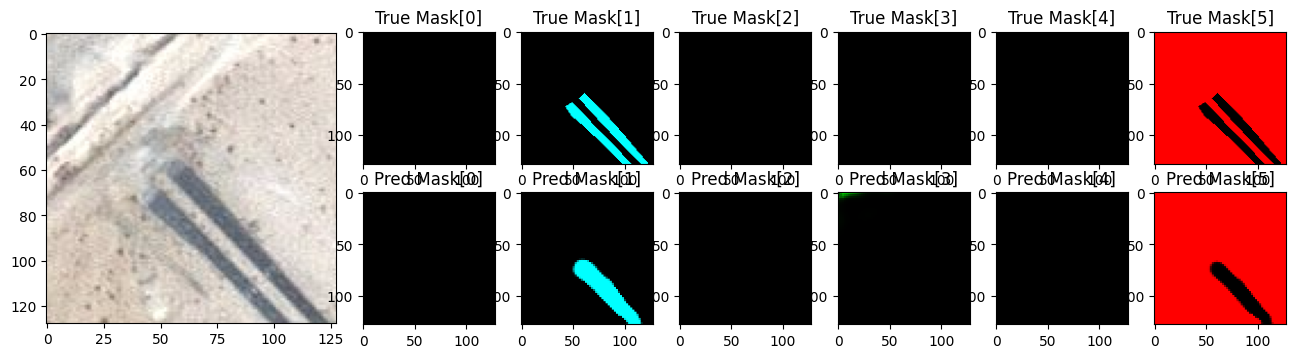

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


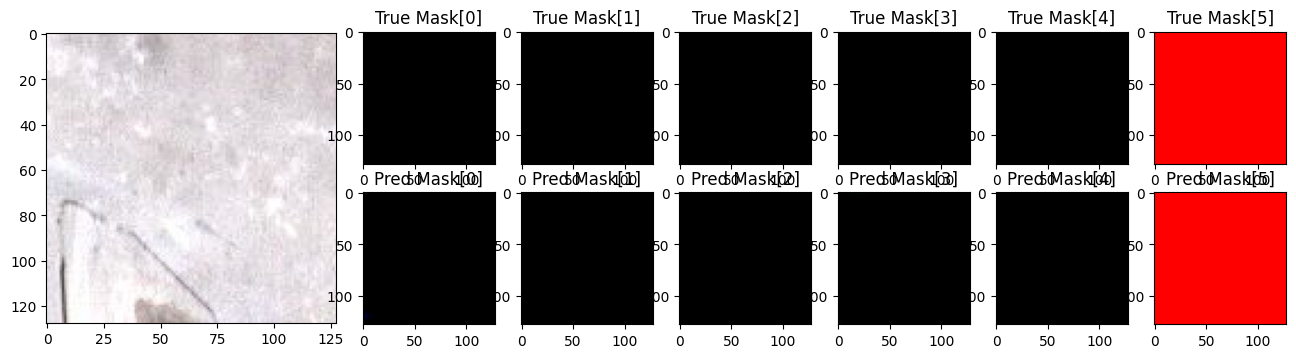

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


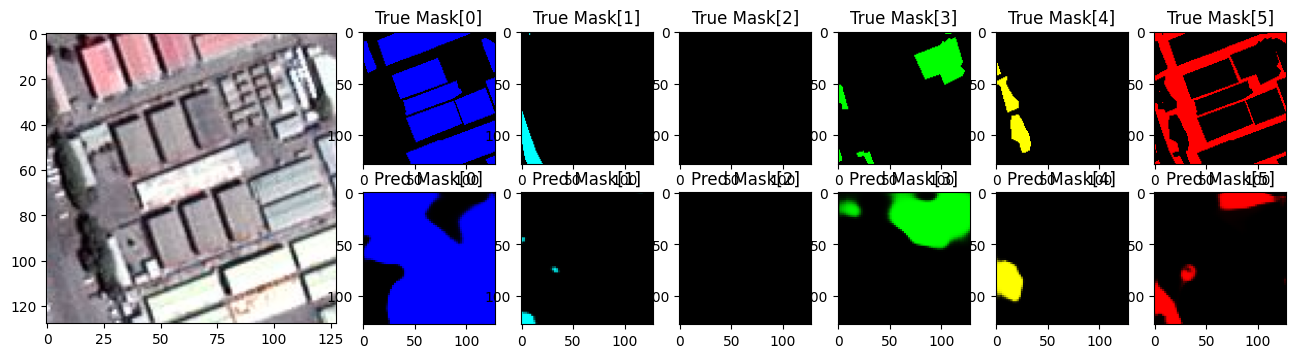

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


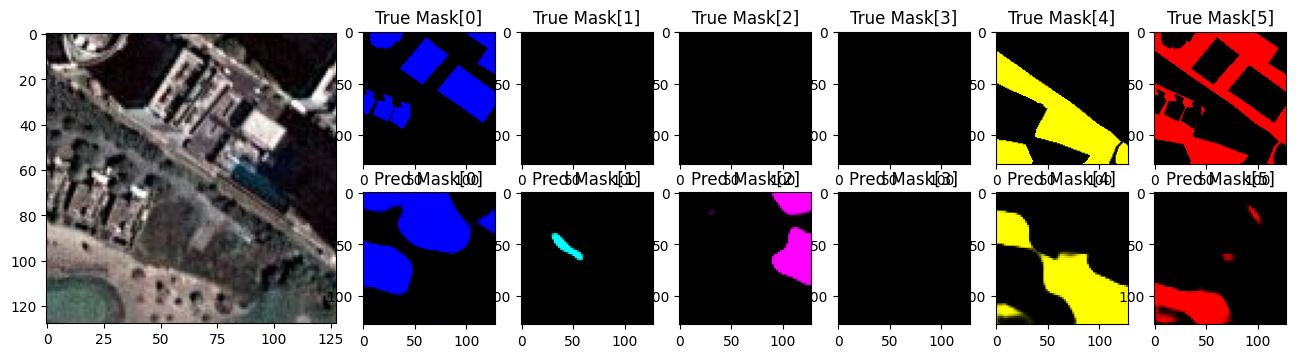

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


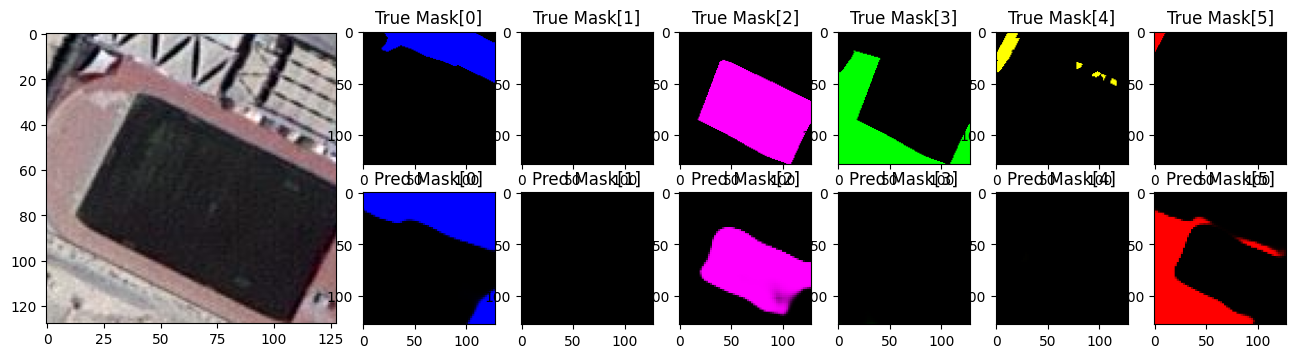

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


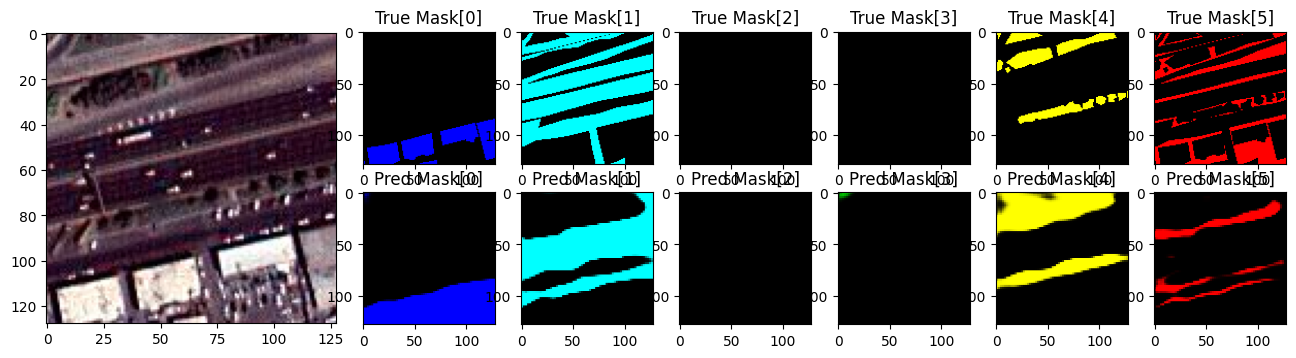

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


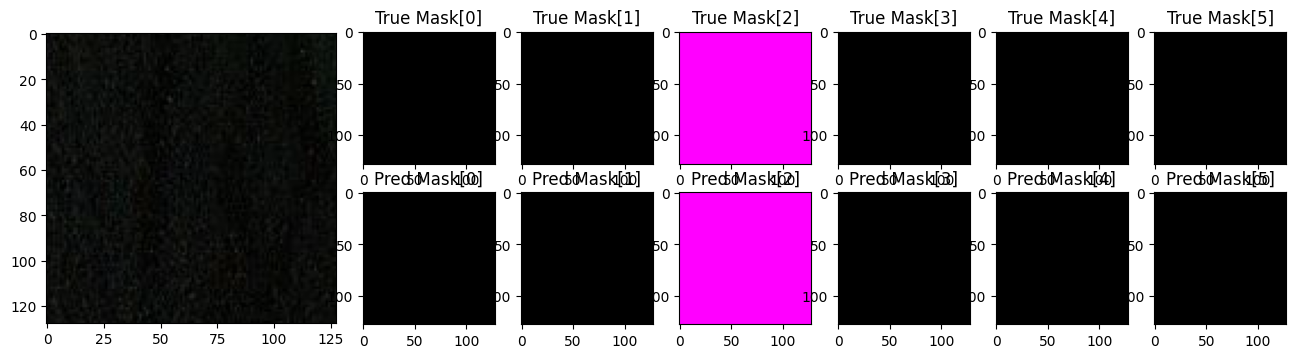

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


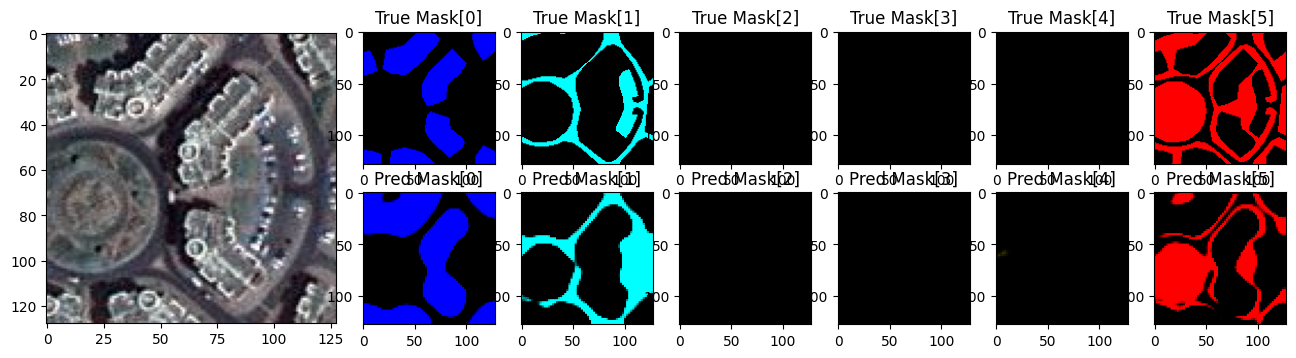

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


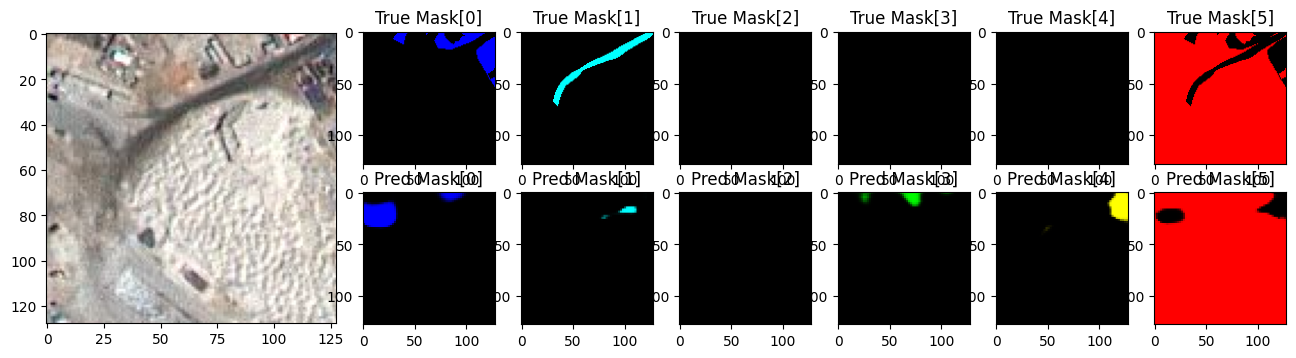

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


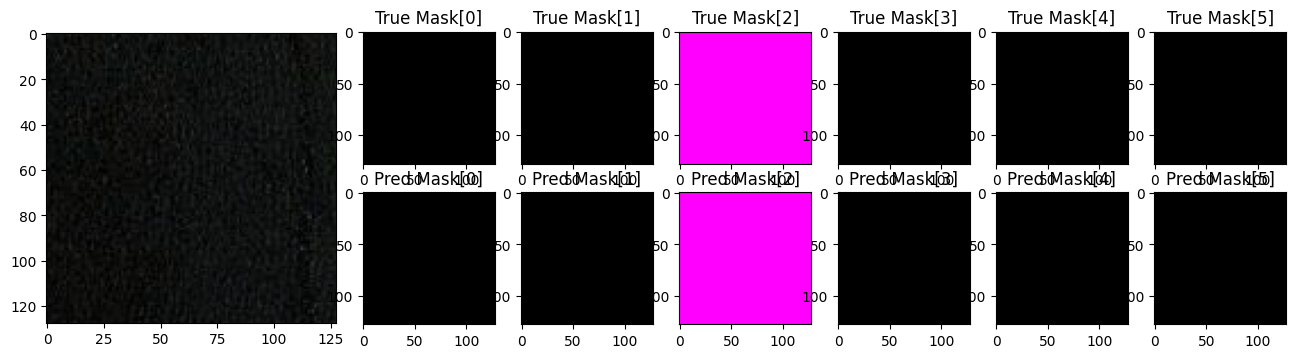

In [11]:
idx_list=[randint(0,63) for _ in range(10)]
for idx in idx_list:
    print(im_test[idx].shape)
    ori=im_test[idx]
    msk=msk_test[idx]
    main="""
    ........
    XXABCDEF
    XXGHIJKL
    ........
    """
    fig, am = plt.subplot_mosaic(main)
    fig.set_size_inches(16,8)
    # fig.set_constrained_layout(True)
    
    # print(msk.shape)
    # for n-th 1 layer mask
    # print(msk)
    res=r=model.predict(ori[None,...])[0]
    am["X"].imshow(im_test[idx])    

    for k in range(0,6):
        am[chr(ord("A")+k)].imshow(msk[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        am[chr(ord("A")+k)].set_title(f"True Mask[{k}]")
        am[chr(ord("G")+k)].imshow(res[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        am[chr(ord("G")+k)].set_title(f"Pred Mask[{k}]")
    # plt.tight_layout()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


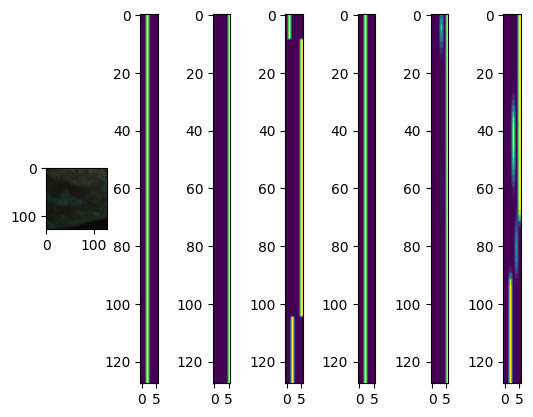

(0.0, 10.0)

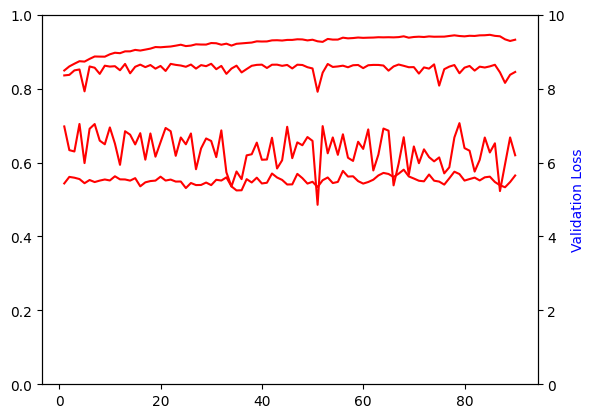

In [12]:
fig,(ix1,ix2,ix3,ix4,ix5,ix6,ix7)=plt.subplots(1,7)
ix1.imshow(im_test[0])

res=r=model.predict(im_test[None,...][0])
ix2.imshow(msk_test[0][0])
ix3.imshow(msk_test[1][0])
ix4.imshow(msk_test[2][0])
# print(res)
ix5.imshow(res[0][0])
ix6.imshow(res[1][0])
ix7.imshow(res[2][0])
plt.show()

val_loss = history.history['val_loss']
val_accuracy_k = history.history.keys()


# Plot the epoch vs val_loss
ax1 = plt.subplot(111)
for _ in val_accuracy_k:
    if _=='val_loss':
        ax2 = ax1.twinx()
        val_loss = history.history[_]
        ax2.plot(epochs_list, val_loss, 'k-')
        ax2.set_ylabel('Validation Loss', color='b')
    else:

        ax1.plot(epochs_list, history.history[_], 'r-')
    # ax1.set_ylabel('Validation Accuracy', color='r')
ax1.set_ylim([0.0, 1])
ax2.set_ylim([0.0, 10])

# Create a second y-axis for the val_accuracy
# ax2 = ax1.twinx()
# ax2.plot(epochs_list, val_loss, 'k-')
# ax2.set_ylabel('Validation Loss', color='b')

In [13]:

weights_path=f"weights/{modelname}.weights.h5"
model.save_weights(weights_path)

model_path=f"models/{modelname}.keras"
model.save(model_path)
print(model_path)


models/unet-128-6ch-L-512-ACT-tanh-LOSS-dice+rms-MET-acc+iou.keras


In [14]:
model_json_path="models/unet-128-single-model-6ch.json"
model.to_json()


'{"module": "keras.src.models.functional", "class_name": "Functional", "config": {"name": "functional_1", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "name": "input_layer"}, "registered_name": null, "name": "input_layer", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [6, 6], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "HeNormal", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer